# <center>**Notebook: Patrones de Hurto a Personas en Colombia: Un Enfoque Espaciotemporal** <center>

21 agosto 2023

**Titulación:** Máster en Big Data y Ciencia de Datos.

**Curso académico:** 2022-2023.

**Alumno:** Jhon Eduard Ruiz Paredes.

**Directora de TFM:** Nery Sofía Huerta Pacheco.


---
# **Inicialización**
---

In [2]:
# Instalación de paquetes necesarios
!pip install --upgrade pip
!pip install --upgrade Pillow
!pip install ydata_profiling
!pip install pysal
!pip install splot
!pip install esda
!pip install libpysal

  Obtaining dependency information for pysal from https://files.pythonhosted.org/packages/71/aa/d4be0ef9f2decda77fdc359e95bd7235654c8d3a2ce34f56ad32c2900d07/pysal-23.7-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 kB 12.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.5/147.5 kB 15.6 MB/s eta 0:00:00
  Obtaining dependency information for spaghetti>=1.6.6 from https://files.pythonhosted.org/packages/d0/c7/2bc5b1dbd132b0ae19d2bd231b679969503d4de496ef17dadd30a4218740/spaghetti-1.7.4-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) .

In [3]:
# Librerías

import calendar
import folium
import json
import io
import math
import pysal as ps

import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
import plotly.subplots as sp
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt

from google.colab import drive
from ydata_profiling import ProfileReport
from scipy.cluster.hierarchy import fcluster
from libpysal.weights import Queen, attach_islands, KNN
from esda.moran import Moran
from esda.moran import Moran_Local
from pysal.lib import weights
from pysal.explore import esda
from splot.esda import lisa_cluster
from splot.esda import moran_scatterplot

/usr/local/lib/python3.10/dist-packages/spaghetti/network.py:40: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


In [4]:
## Cargue de BD y vista preliminar de la información.
drive.mount('/content/drive')
df = pd.read_excel('/content/drive/MyDrive/Maestría/TFM - Jhon/BD/BD_Hurtos.xlsx')
df

Mounted at /content/drive


Departamento            Municipio                 Armas Medios   Año  \
0          AMAZONAS         LETICIA (CT)  ARMA BLANCA / CORTOPUNZANTE  2020   
1          AMAZONAS         LETICIA (CT)  ARMA BLANCA / CORTOPUNZANTE  2020   
2          AMAZONAS         LETICIA (CT)  ARMA BLANCA / CORTOPUNZANTE  2020   
3          AMAZONAS         LETICIA (CT)  ARMA BLANCA / CORTOPUNZANTE  2020   
4          AMAZONAS         LETICIA (CT)  ARMA BLANCA / CORTOPUNZANTE  2020   
...             ...                  ...                          ...   ...   
218746      VICHADA  PUERTO CARREÑO (CT)          SIN EMPLEO DE ARMAS  2022   
218747      VICHADA  PUERTO CARREÑO (CT)          SIN EMPLEO DE ARMAS  2022   
218748      VICHADA  PUERTO CARREÑO (CT)          SIN EMPLEO DE ARMAS  2022   
218749      VICHADA  PUERTO CARREÑO (CT)                          NaN  2022   
218750      VICHADA        SANTA ROSALÍA          SIN EMPLEO DE ARMAS  2022   

        Mes     Género Tipo de persona  Cantidad  
0       ene  MASCULINO         ADULTOS         1  
1       mar   FEMENINO         ADULTOS         3  
2       jun  MASCULINO    ADOLESCENTES         1  
3       ago  MASCULINO         ADULTOS         2  
4       sep   FEMENINO         ADULTOS         1  
...     ...        ...             ...       ...  
218746  nov   FEMENINO         ADULTOS         2  
218747  nov  MASCULINO         ADULTOS         4  
218748  dic  MASCULINO         ADULTOS         1  
218749  nov  MASCULINO         ADULTOS         1  
218750  ene  MASCULINO         ADULTOS         1  

[218751 rows x 8 columns]

In [5]:
# Cantidad de filas y columnas de dataset.
print('Cantidad de Filas y columnas:',df.shape)
print('Nombre columnas:',df.columns)

Cantidad de Filas y columnas: (218751, 8)
Nombre columnas: Index(['Departamento', 'Municipio', 'Armas Medios', 'Año', 'Mes', 'Género',
       'Tipo de persona', 'Cantidad'],
      dtype='object')


In [6]:
# Estadística descriptiva de la variable: Cantidad
df['Cantidad'].describe()

count    218751.000000
mean         10.343628
std          83.814417
min           1.000000
25%           1.000000
50%           1.000000
75%           4.000000
max        5990.000000
Name: Cantidad, dtype: float64

In [7]:
# Reemplazo de los valores de los meses
# Definir la lista de abreviaturas de los meses en minúsculas
abreviaturas = ['ene', 'feb', 'mar', 'abr', 'may', 'jun', 'jul', 'ago', 'sep', 'oct', 'nov', 'dic']

# Mapear las abreviaturas a los números de los meses correspondientes
df['NumeroMes'] = df['Mes'].map(lambda x: abreviaturas.index(x.lower()) + 1)

# Imprimir el DataFrame con el número del mes
print(df)

       Departamento            Municipio                 Armas Medios   Año  \
0          AMAZONAS         LETICIA (CT)  ARMA BLANCA / CORTOPUNZANTE  2020   
1          AMAZONAS         LETICIA (CT)  ARMA BLANCA / CORTOPUNZANTE  2020   
2          AMAZONAS         LETICIA (CT)  ARMA BLANCA / CORTOPUNZANTE  2020   
3          AMAZONAS         LETICIA (CT)  ARMA BLANCA / CORTOPUNZANTE  2020   
4          AMAZONAS         LETICIA (CT)  ARMA BLANCA / CORTOPUNZANTE  2020   
...             ...                  ...                          ...   ...   
218746      VICHADA  PUERTO CARREÑO (CT)          SIN EMPLEO DE ARMAS  2022   
218747      VICHADA  PUERTO CARREÑO (CT)          SIN EMPLEO DE ARMAS  2022   
218748      VICHADA  PUERTO CARREÑO (CT)          SIN EMPLEO DE ARMAS  2022   
218749      VICHADA  PUERTO CARREÑO (CT)                          NaN  2022   
218750      VICHADA        SANTA ROSALÍA          SIN EMPLEO DE ARMAS  2022   

        Mes     Género Tipo de persona  Cantidad  N

---
# **Exploración de los datos**
---

## Análisis descriptivo

In [8]:
#Exploración descriptiva de la información
profile = ProfileReport(df, title="Profiling Report")
profile.to_file("Reporte.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Análisis exploratorio.

### Distribución del género entre los departamentos.

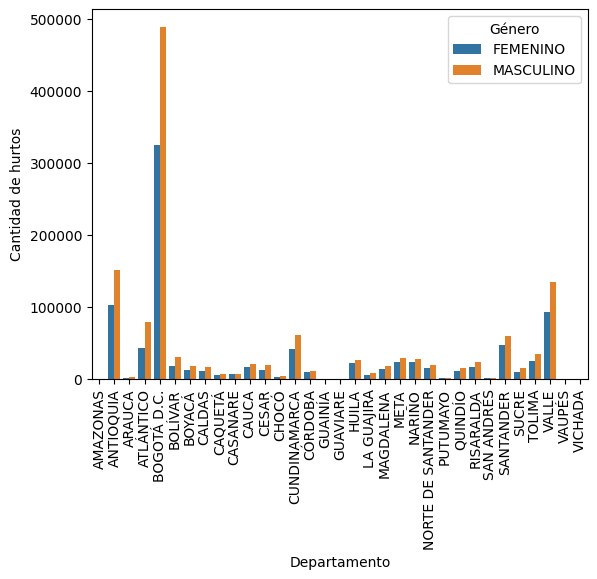

In [71]:
#Departamento - Género (Cantidad de hurtos)

# Agrupar los datos por departamento y género, y calcular la suma de la cantidad de hurtos en cada grupo
tabla_grupo_dep_genero = df.groupby(['Departamento', 'Género'])['Cantidad'].sum().reset_index()

# Gráfico de barras con alturas
ax = sns.barplot(x='Departamento', y='Cantidad', hue='Género', data=tabla_grupo_dep_genero, estimator=sum)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.xlabel('Departamento')
plt.ylabel('Cantidad de hurtos')

# Ajustar la posición de la leyenda para evitar superposición
plt.legend(title='Género', loc='upper right')  # Puedes cambiar 'upper right' por otras posiciones según tus necesidades
plt.show()

Género               FEMENINO  MASCULINO
Departamento                            
AMAZONAS            46.257359  53.742641
ANTIOQUIA           40.677426  59.322574
ARAUCA              44.325082  55.674918
ATLÁNTICO           35.561486  64.438514
BOGOTÁ D.C.         39.988875  60.011125
BOLÍVAR             37.901844  62.098156
BOYACÁ              40.280177  59.719823
CALDAS              40.797283  59.202717
CAQUETÁ             49.100705  50.899295
CASANARE            46.800465  53.199535
CAUCA               44.325754  55.674246
CESAR               39.009524  60.990476
CHOCÓ               43.567291  56.432709
CUNDINAMARCA        41.059467  58.940533
CÓRDOBA             44.478135  55.521865
GUAINÍA             38.842975  61.157025
GUAVIARE            41.062802  58.937198
HUILA               45.607457  54.392543
LA GUAJIRA          41.990887  58.009113
MAGDALENA           42.132201  57.867799
META                44.315511  55.684489
NARIÑO              46.058131  53.941869
NORTE DE SANTAND

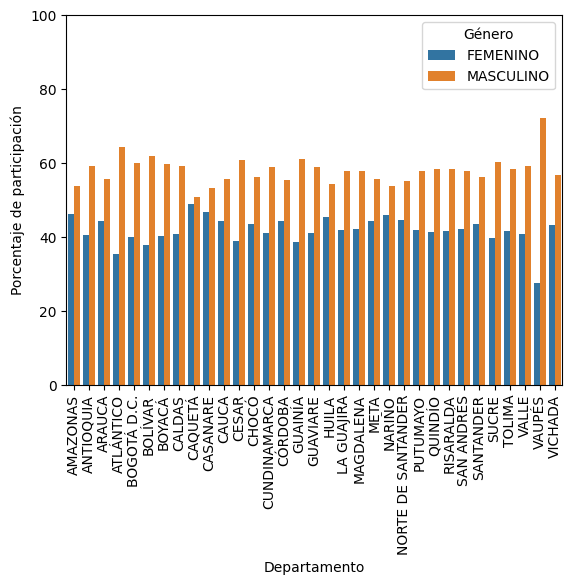

In [72]:
#Departamento - Género (Porcentaje de hurtos)
tabla_grupo_dep_genero['Porcentaje'] = tabla_grupo_dep_genero.groupby('Departamento')['Cantidad'].transform(lambda x: x / x.sum() * 100)
tabla_contingencia_dep_genero = tabla_grupo_dep_genero.pivot(index='Departamento', columns='Género', values='Porcentaje')
print(tabla_contingencia_dep_genero)
tabla_contingencia_dep_genero.to_excel('tabla_contingencia_dep_genero.xlsx')

# Gráfico de barras con alturas proporcionales
ax = sns.barplot(x='Departamento', y='Porcentaje', hue='Género', data=tabla_grupo_dep_genero, estimator=sum)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.xlabel('Departamento')
plt.ylabel('Porcentaje de participación')

# Ajustar el límite del eje y (por ejemplo, para aumentar el límite superior)
ax.set_ylim(0, 100)

# Ajustar la posición de la leyenda para evitar superposición
plt.legend(title='Género', loc='upper right')  # Puedes cambiar 'upper right' por otras posiciones según tus necesidades

plt.show()

### Trayectorias del nivel de hurtos en Colombia por mes y año.

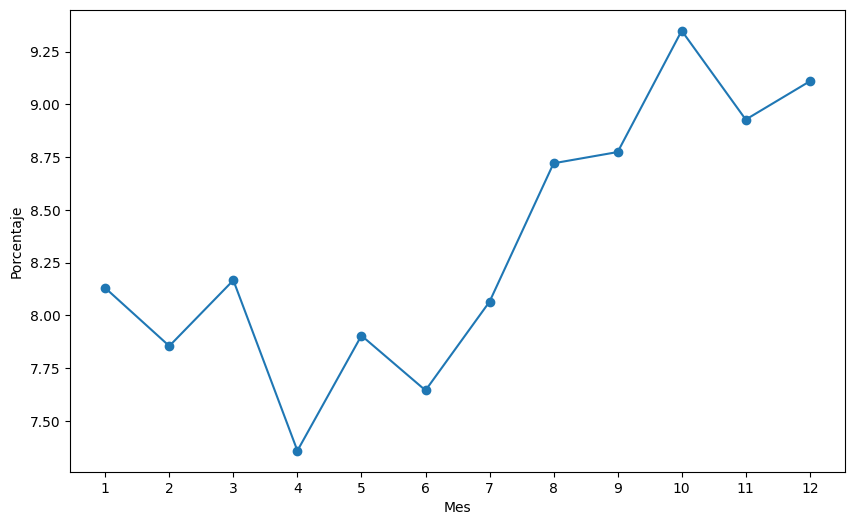

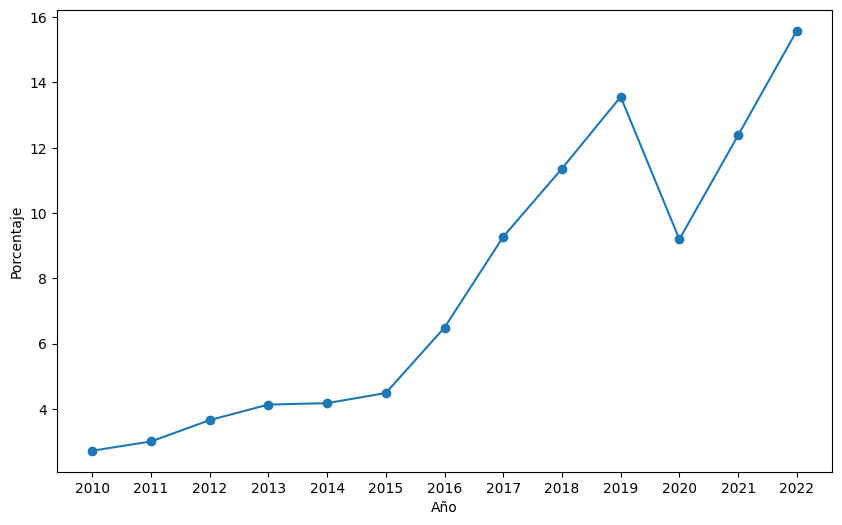

In [73]:
# Agrupar los datos por mes, y calcular la suma de la cantidad de hurtos en cada grupo
tabla_grupo_mes = df.groupby(['NumeroMes'])['Cantidad'].sum().reset_index()

# Calcular el porcentaje de participación
total_cantidad = tabla_grupo_mes['Cantidad'].sum()
tabla_grupo_mes['Porcentaje'] = (tabla_grupo_mes['Cantidad'] / total_cantidad) * 100

# Crear la serie de tiempo
plt.figure(figsize=(10, 6))
plt.plot(tabla_grupo_mes['NumeroMes'], tabla_grupo_mes['Porcentaje'], marker='o')
plt.xlabel('Mes')
plt.ylabel('Porcentaje')
plt.xticks(tabla_grupo_mes['NumeroMes'])
plt.show()

# Agrupar los datos por año, y calcular la suma de la cantidad de hurtos en cada grupo
tabla_grupo_ano = df.groupby(['Año'])['Cantidad'].sum().reset_index()

# Calcular el porcentaje de participación
total_cantidad = tabla_grupo_ano['Cantidad'].sum()
tabla_grupo_ano['Porcentaje'] = (tabla_grupo_ano['Cantidad'] / total_cantidad) * 100

# Crear la serie de tiempo
plt.figure(figsize=(10, 6))
plt.plot(tabla_grupo_ano['Año'], tabla_grupo_ano['Porcentaje'], marker='o')
plt.xlabel('Año')
plt.ylabel('Porcentaje')
plt.xticks(tabla_grupo_ano['Año'])
plt.show()

### Trayectorias del nivel de hurtos por departamento y mes.

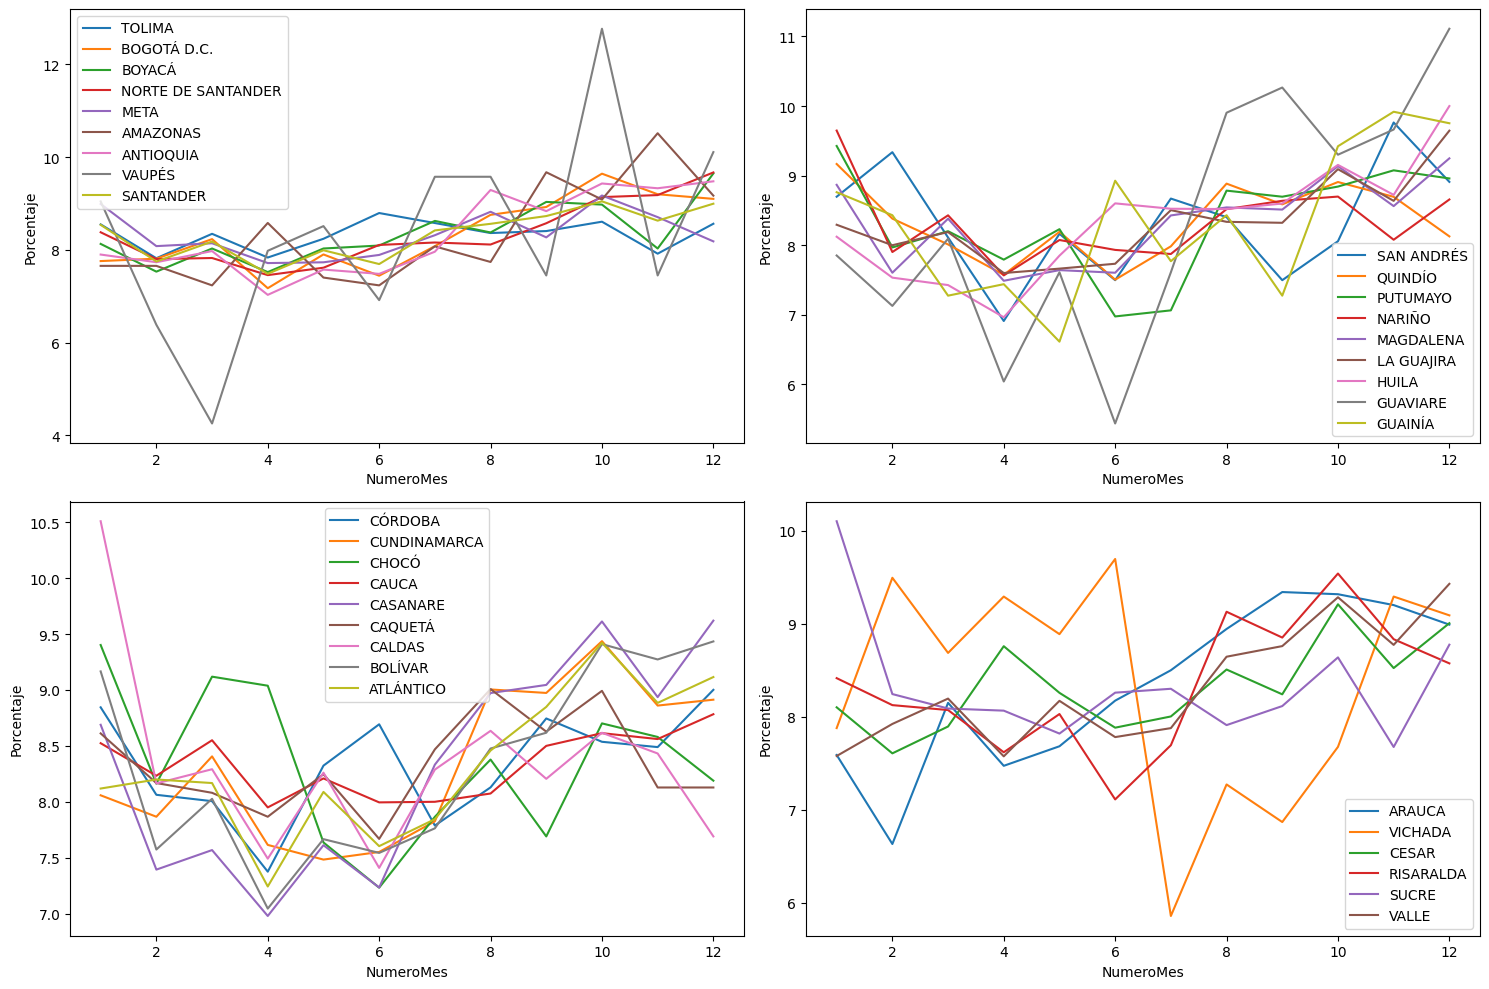

In [74]:
# Agrupar los datos por departamento y mes, y calcular la suma de la cantidad de hurtos en cada grupo
tabla_grupo_dep_mes = df.groupby(['Departamento', 'NumeroMes'])['Cantidad'].sum().reset_index()
tabla_grupo_dep_mes['Porcentaje'] = tabla_grupo_dep_mes.groupby('Departamento')['Cantidad'].transform(lambda x: x / x.sum() * 100)
tabla_contingencia_dep_mes_por = pd.DataFrame(tabla_grupo_dep_mes.pivot(index='Departamento', columns='NumeroMes', values='Porcentaje'))

# Ordenar la tabla de contingencia por el porcentaje de hurtos en cada departamento
tabla_contingencia_dep_mes_por_sorted = tabla_contingencia_dep_mes_por.sum(axis=1).sort_values(ascending=False)

# Obtener la lista de departamentos ordenados
dep_sorted = tabla_contingencia_dep_mes_por_sorted.index

# Dividir los departamentos
grupos_dep_sorted = [dep_sorted[i:i+9] for i in range(0, len(dep_sorted), 9)]

# Graficar la serie de tiempo por grupo de departmentos ordenados
num_graficos_por_fila = 2
num_filas = (len(grupos_dep_sorted) + num_graficos_por_fila - 1) // num_graficos_por_fila

fig, axs = plt.subplots(num_filas, num_graficos_por_fila, figsize=(15, 5*num_filas))

for i, grupo in enumerate(grupos_dep_sorted):
    fila = i // num_graficos_por_fila
    columna = i % num_graficos_por_fila

    for Departamento in grupo:
        datos_dep = tabla_contingencia_dep_mes_por.loc[Departamento]
        axs[fila, columna].plot(datos_dep.index, datos_dep.values, label=Departamento)

    # Configurar el gráfico del grupo de departamentos
    axs[fila, columna].set_xlabel('NumeroMes')
    axs[fila, columna].set_ylabel('Porcentaje')
    axs[fila, columna].legend()

# Ajustar los espacios entre los gráficos
plt.tight_layout()

# Mostrar los gráficos
plt.show()

### Trayectorias del nivel de hurtos por departamento y año.

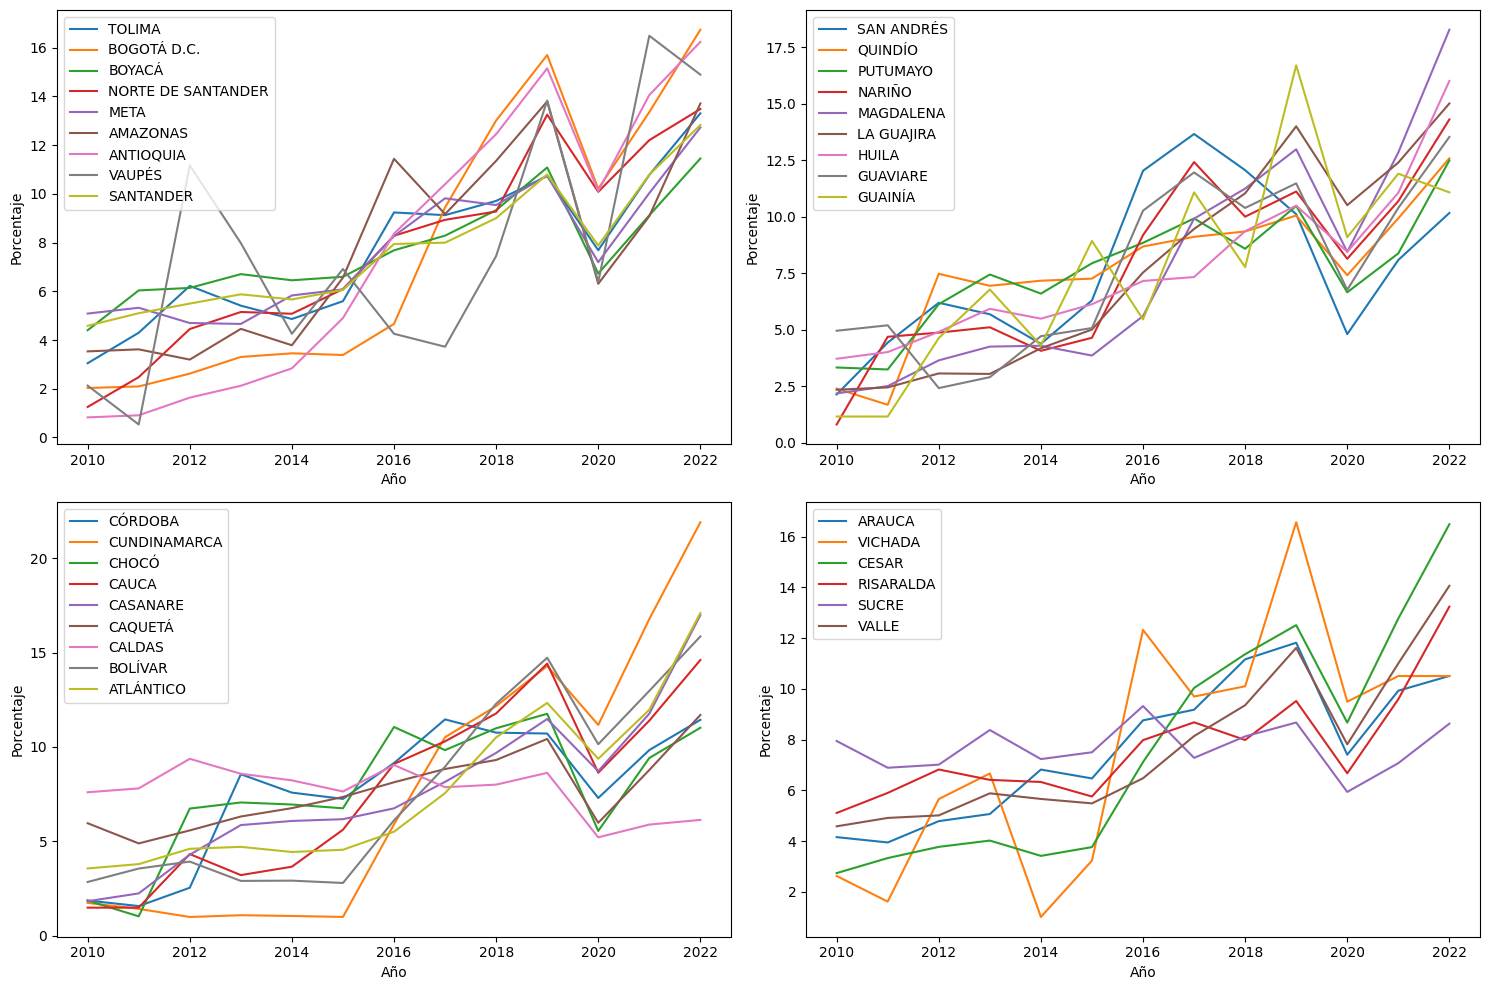

In [75]:
# Agrupar los datos por departamento y año, y calcular la suma de la cantidad de hurtos en cada grupo
#Departamento - Año (Cantidad de hurtos)

# Agrupar los datos por departamento y año, y calcular la suma de la cantidad de hurtos en cada grupo
tabla_grupo_dep_ano = df.groupby(['Departamento', 'Año'])['Cantidad'].sum().reset_index()
tabla_grupo_dep_ano['Porcentaje'] = tabla_grupo_dep_ano.groupby('Departamento')['Cantidad'].transform(lambda x: x / x.sum() * 100)
tabla_contingencia_dep_ano_por = pd.DataFrame(tabla_grupo_dep_ano.pivot(index='Departamento', columns='Año', values='Porcentaje'))

# Ordenar la tabla de contingencia por la suma total de hurtos en cada departamento
tabla_contingencia_dep_ano_sorted = tabla_contingencia_dep_ano_por.sum(axis=1).sort_values(ascending=False)

fig, axs = plt.subplots(num_filas, num_graficos_por_fila, figsize=(15, 5*num_filas))

for i, grupo in enumerate(grupos_dep_sorted):
    fila = i // num_graficos_por_fila
    columna = i % num_graficos_por_fila

    for Departamento in grupo:
        datos_dep = tabla_contingencia_dep_ano_por.loc[Departamento]
        axs[fila, columna].plot(datos_dep.index, datos_dep.values, label=Departamento)

    # Configurar el gráfico del grupo de departamentos
    axs[fila, columna].set_xlabel('Año')
    axs[fila, columna].set_ylabel('Porcentaje')
    axs[fila, columna].legend()

# Ajustar los espacios entre los gráficos
plt.tight_layout()

# Mostrar los gráficos
plt.show()

### Distribución del hurto a personas por departamento y mes.

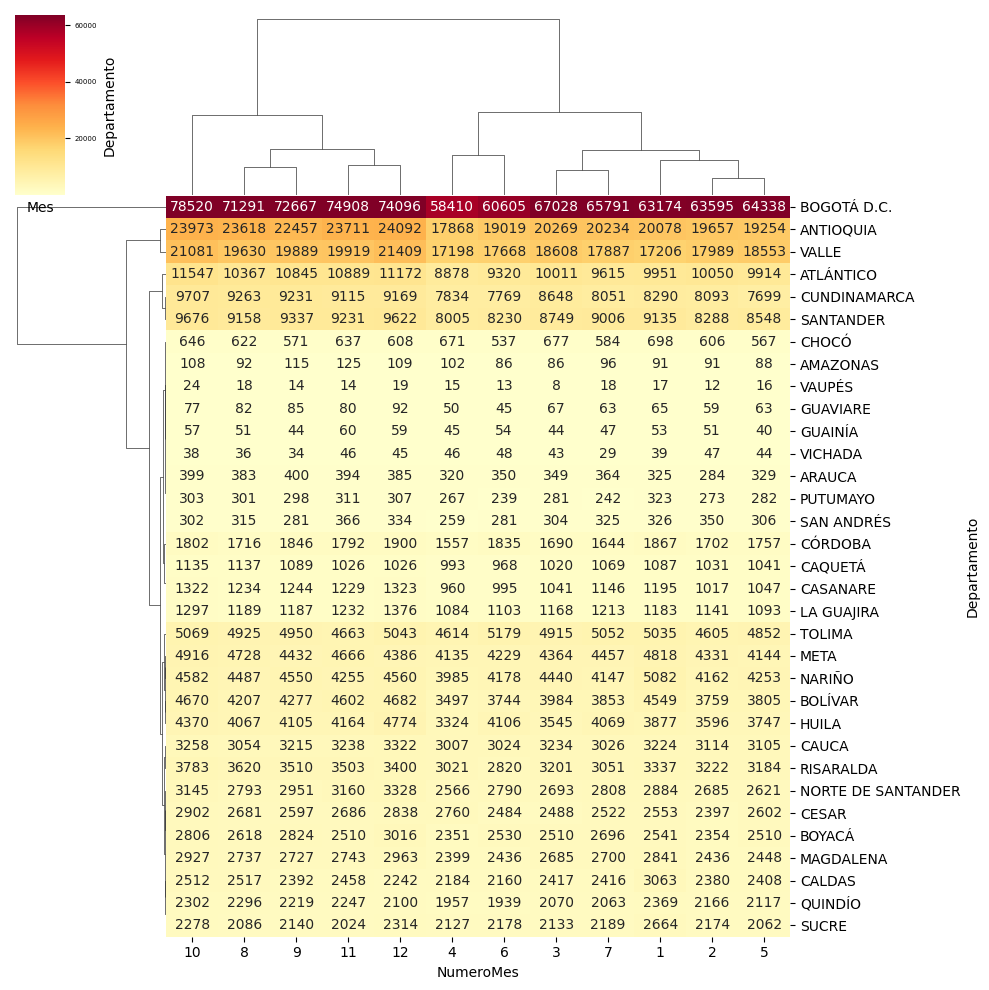

In [76]:
#Departamento - Mes (Cantidad de hurtos)

# Crear una tabla de contingencia con el departamento como índice y el número del mes como columnas
tabla_contingencia_dep_mes = pd.pivot_table(tabla_grupo_dep_mes, values='Cantidad', index='Departamento', columns='NumeroMes')

# Crear el mapa de calor utilizando la tabla de contingencia con la cantidad absoluta
sns.clustermap(tabla_contingencia_dep_mes, cmap='YlOrRd', annot=True, fmt='.0f', robust=True, cbar_kws={'label': 'Cantidad de Hurtos'})

# Ajustar el tamaño de la fuente para las etiquetas del eje x e y
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)

plt.xlabel('Mes')
plt.ylabel('Departamento')

plt.show()

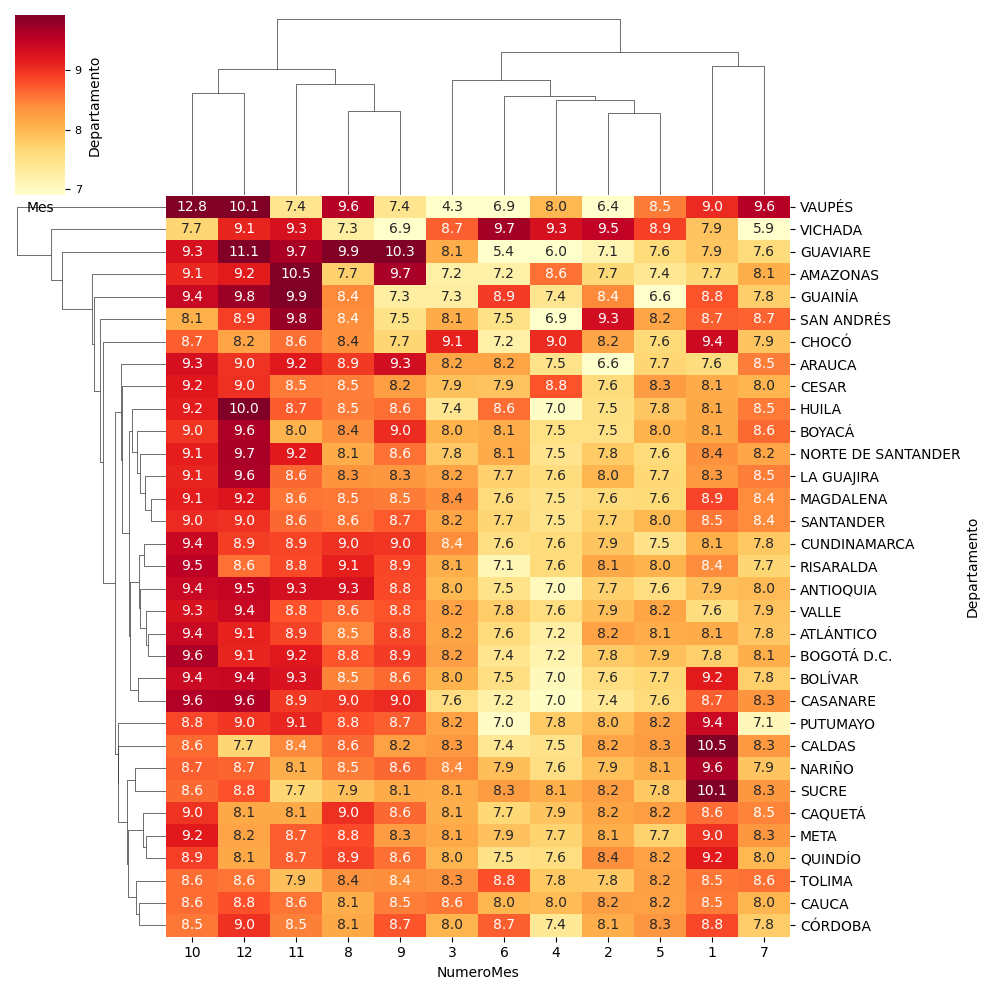

In [77]:
#Departamento - Mes (Porcentaje de hurtos)

# Crear el mapa de calor utilizando la tabla de contingencia con la cantidad estandarizada
sns.clustermap(tabla_contingencia_dep_mes_por, cmap='YlOrRd', annot=True, fmt='.1f', robust=True, cbar_kws={'label': 'Cantidad de Hurtos'})

# Ajustar el tamaño de la fuente para las etiquetas del eje x e y
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.xlabel('Mes')
plt.ylabel('Departamento')

plt.show()

### Distribución del hurto a personas por departamento y año.

Text(325.06186868686865, 0.5, 'Departamento')

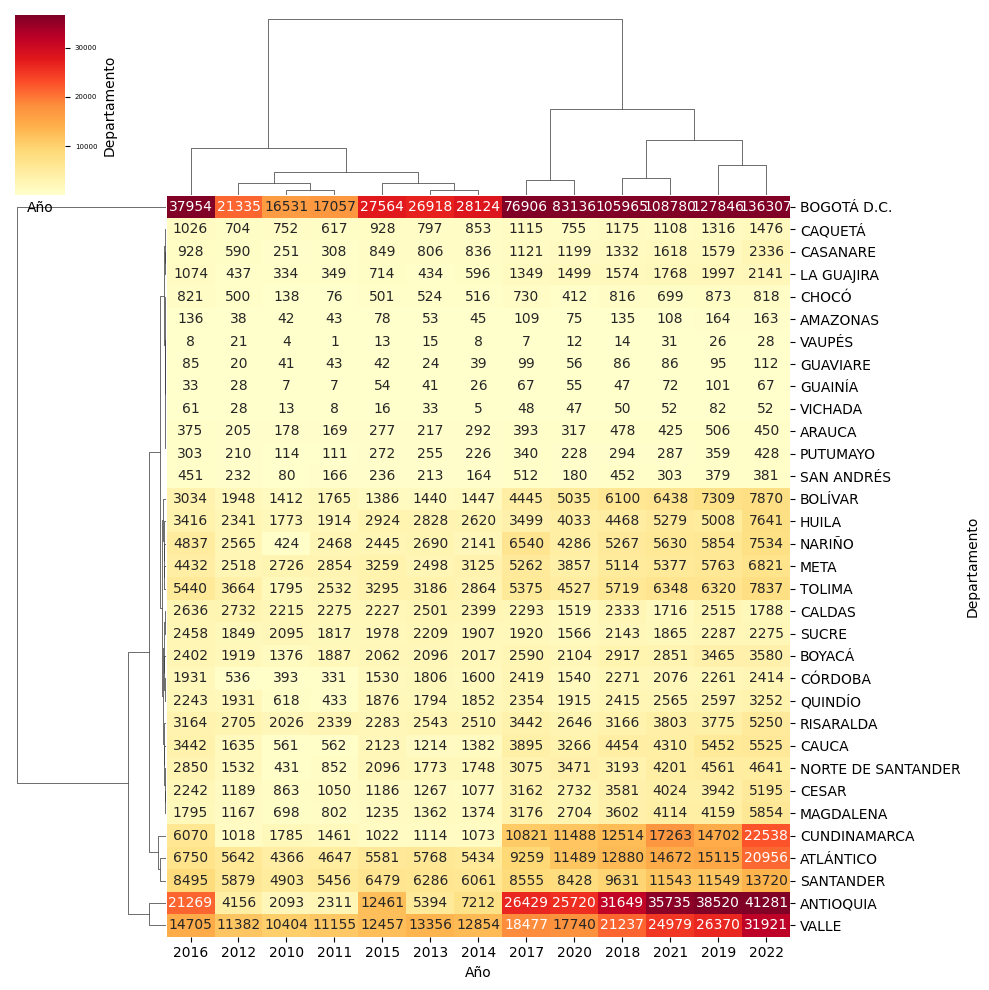

In [78]:
#Departamento - Año (Cantidad de hurtos)

# Crear una tabla de contingencia con el departamento como índice y el número del mes como columnas
tabla_contingencia_dep_ano = pd.pivot_table(tabla_grupo_dep_ano, values='Cantidad', index='Departamento', columns='Año')

# Crear el mapa de calor utilizando la tabla de contingencia con la cantidad absoluta
sns.clustermap(tabla_contingencia_dep_ano, cmap='YlOrRd', annot=True, fmt='.0f', robust=True, cbar_kws={'label': 'Cantidad de Hurtos'})

# Ajustar el tamaño de la fuente para las etiquetas del eje x e y
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)

plt.xlabel('Año')
plt.ylabel('Departamento')


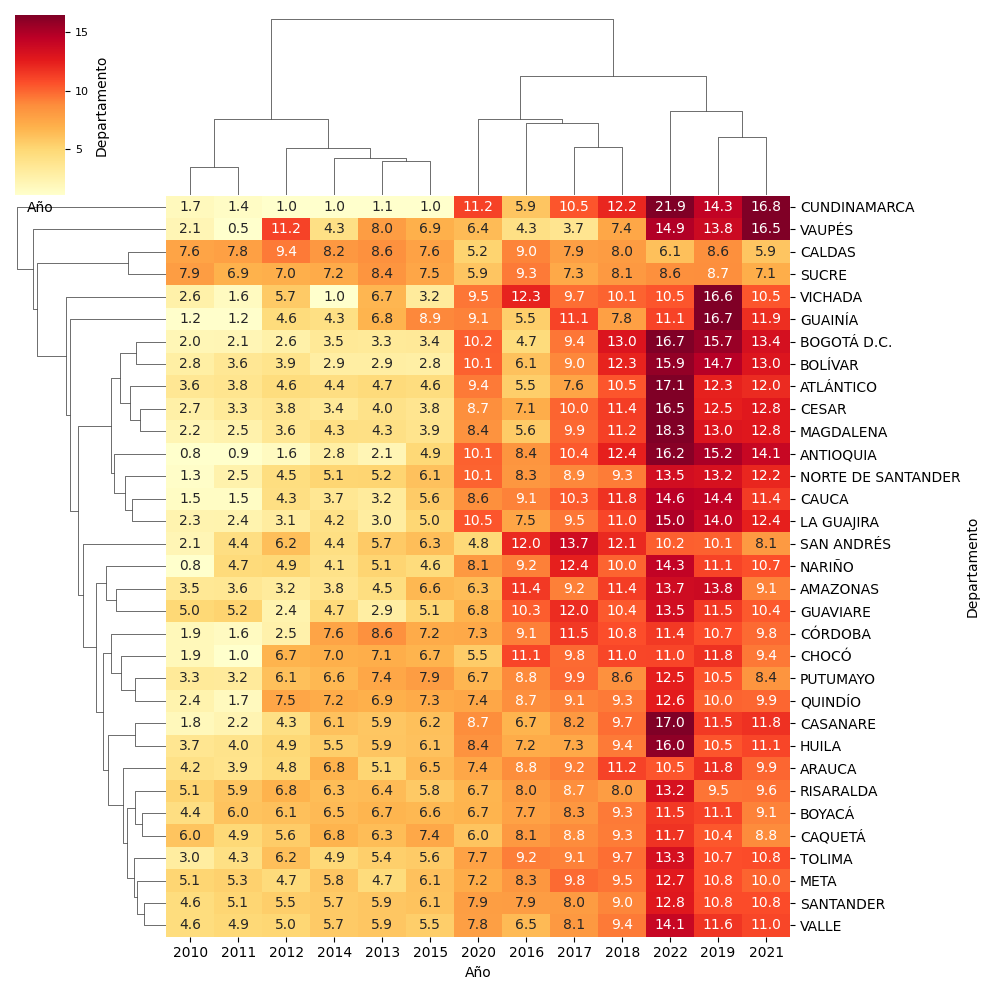

In [79]:
#Departamento - Año (Cantidad de hurtos)

# Crear el mapa de calor utilizando la tabla de contingencia con la cantidad estandarizada
sns.clustermap(tabla_contingencia_dep_ano_por, cmap='YlOrRd', annot=True, fmt='.1f', robust=True, cbar_kws={'label': 'Cantidad de Hurtos'})

# Ajustar el tamaño de la fuente para las etiquetas del eje x e y
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.xlabel('Año')
plt.ylabel('Departamento')

plt.show()

### Distribución espacial mensual del hurto a personas por departamentos.

In [32]:
#Enlace para descargar el shape de los departamentos de Colombia
# https://drive.google.com/file/d/1N5IkE3a_q3wapPJPpQViQyClGKEz2vAe/view?usp=drive_link
!wget 'https://drive.google.com/uc?export=download&id=1N5IkE3a_q3wapPJPpQViQyClGKEz2vAe' -O ColDep.zip

!unzip ColDep.zip

Departamentos = gpd.read_file('MGN_DPTO_POLITICO.shp')
Departamentos.columns.values

--2023-08-19 20:47:44--  https://drive.google.com/uc?export=download&id=1N5IkE3a_q3wapPJPpQViQyClGKEz2vAe
Resolving drive.google.com (drive.google.com)... 172.253.122.138, 172.253.122.113, 172.253.122.101, ...
Connecting to drive.google.com (drive.google.com)|172.253.122.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-1g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/do82kqb37lmrft24kcrr9fif0dp4og88/1692478050000/12653930227734307627/*/1N5IkE3a_q3wapPJPpQViQyClGKEz2vAe?e=download&uuid=fa4af58c-58fe-4bc7-8661-9d3468fbdc03 [following]
--2023-08-19 20:47:48--  https://doc-08-1g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/do82kqb37lmrft24kcrr9fif0dp4og88/1692478050000/12653930227734307627/*/1N5IkE3a_q3wapPJPpQViQyClGKEz2vAe?e=download&uuid=fa4af58c-58fe-4bc7-8661-9d3468fbdc03
Resolving doc-08-1g-docs.googleusercontent.com (doc-08-1g-docs.googleusercontent.com)... 142.251.163.132, 

array(['DPTO_CCDGO', 'DPTO_CNMBR', 'DPTO_ANO_C', 'DPTO_ACT_A',
       'DPTO_NAREA', 'DPTO_CSMBL', 'DPTO_VGNC', 'Shape_Leng',
       'Shape_Area', 'geometry'], dtype=object)

In [33]:
#Lista de los departamentos del Shape
Departamentos['DPTO_CNMBR'].unique()

array(['ANTIOQUIA', 'ATLÃ\x81NTICO', 'BOGOTÃ\x81, D.C.', 'BOLÃ\x8dVAR',
       'BOYACÃ\x81', 'CALDAS', 'CAQUETÃ\x81', 'CAUCA', 'CESAR',
       'CÃ\x93RDOBA', 'CUNDINAMARCA', 'CHOCÃ\x93', 'HUILA', 'LA GUAJIRA',
       'MAGDALENA', 'META', 'NARIÃ\x91O', 'NORTE DE SANTANDER', 'QUINDIO',
       'RISARALDA', 'SANTANDER', 'SUCRE', 'TOLIMA', 'VALLE DEL CAUCA',
       'ARAUCA', 'CASANARE', 'PUTUMAYO',
       'ARCHIPIÃ\x89LAGO DE SAN ANDRÃ\x89S, PROVIDENCIA Y SANTA CATALINA',
       'AMAZONAS', 'GUAINÃ\x8dA', 'GUAVIARE', 'VAUPÃ\x89S', 'VICHADA'],
      dtype=object)

In [34]:
#Ajuste de los nombres de los departamentos de acuerdo con la base de datos utilizada

Departamentos['DPTO_CNMBR'] = Departamentos['DPTO_CNMBR'].replace('ATLÃ\x81NTICO', 'ATLÁNTICO')
Departamentos['DPTO_CNMBR'] = Departamentos['DPTO_CNMBR'].replace('BOGOTÃ\x81, D.C.', 'BOGOTÁ D.C.')
Departamentos['DPTO_CNMBR'] = Departamentos['DPTO_CNMBR'].replace('BOLÃ\x8dVAR', 'BOLÍVAR')
Departamentos['DPTO_CNMBR'] = Departamentos['DPTO_CNMBR'].replace('BOYACÃ\x81', 'BOYACÁ')
Departamentos['DPTO_CNMBR'] = Departamentos['DPTO_CNMBR'].replace('CAQUETÃ\x81', 'CAQUETÁ')
Departamentos['DPTO_CNMBR'] = Departamentos['DPTO_CNMBR'].replace('CÃ\x93RDOBA', 'CÓRDOBA')
Departamentos['DPTO_CNMBR'] = Departamentos['DPTO_CNMBR'].replace('CHOCÃ\x93', 'CHOCÓ')
Departamentos['DPTO_CNMBR'] = Departamentos['DPTO_CNMBR'].replace('NARIÃ\x91O', 'NARIÑO')
Departamentos['DPTO_CNMBR'] = Departamentos['DPTO_CNMBR'].replace('QUINDIO', 'QUINDÍO')
Departamentos['DPTO_CNMBR'] = Departamentos['DPTO_CNMBR'].replace('VALLE DEL CAUCA', 'VALLE')
Departamentos['DPTO_CNMBR'] = Departamentos['DPTO_CNMBR'].replace('ARCHIPIÃ\x89LAGO DE SAN ANDRÃ\x89S, PROVIDENCIA Y SANTA CATALINA', 'SAN ANDRÉS')
Departamentos['DPTO_CNMBR'] = Departamentos['DPTO_CNMBR'].replace('GUAINÃ\x8dA', 'GUAINÍA')
Departamentos['DPTO_CNMBR'] = Departamentos['DPTO_CNMBR'].replace('VAUPÃ\x89S', 'VAUPÉS')
Departamentos['DPTO_CNMBR'].unique()

array(['ANTIOQUIA', 'ATLÁNTICO', 'BOGOTÁ D.C.', 'BOLÍVAR', 'BOYACÁ',
       'CALDAS', 'CAQUETÁ', 'CAUCA', 'CESAR', 'CÓRDOBA', 'CUNDINAMARCA',
       'CHOCÓ', 'HUILA', 'LA GUAJIRA', 'MAGDALENA', 'META', 'NARIÑO',
       'NORTE DE SANTANDER', 'QUINDÍO', 'RISARALDA', 'SANTANDER', 'SUCRE',
       'TOLIMA', 'VALLE', 'ARAUCA', 'CASANARE', 'PUTUMAYO', 'SAN ANDRÉS',
       'AMAZONAS', 'GUAINÍA', 'GUAVIARE', 'VAUPÉS', 'VICHADA'],
      dtype=object)

In [89]:
# Agrupar los datos por departamento y nombre del mes, y calcular la suma de la cantidad de hurtos en cada grupo
tabla_grupo_dep_nom_mes = df.groupby(['Departamento', 'Mes'])['Cantidad'].sum().reset_index()
tabla_grupo_dep_nom_mes['Porcentaje'] = tabla_grupo_dep_nom_mes.groupby('Departamento')['Cantidad'].transform(lambda x: x / x.sum() * 100)

tabla_contingencia_dep_nom_mes = pd.DataFrame(tabla_grupo_dep_nom_mes.pivot(index='Departamento', columns='Mes', values='Cantidad'))
tabla_contingencia_dep_nom_mes_por = pd.DataFrame(tabla_grupo_dep_nom_mes.pivot(index='Departamento', columns='Mes', values='Porcentaje'))

tabla_contingencia_dep_nom_mes = tabla_contingencia_dep_nom_mes.reset_index()
tabla_contingencia_dep_nom_mes_por = tabla_contingencia_dep_nom_mes_por.reset_index()

tabla_contingencia_dep_nom_mes = tabla_contingencia_dep_nom_mes.rename(columns={'Departamento': 'DPTO_CNMBR'})
tabla_contingencia_dep_nom_mes_por = tabla_contingencia_dep_nom_mes_por.rename(columns={'Departamento': 'DPTO_CNMBR'})

# Definir el orden de los meses
orden_meses = ['DPTO_CNMBR', 'ene', 'feb', 'mar', 'abr', 'may', 'jun', 'jul', 'ago', 'sep', 'oct', 'nov', 'dic']

# Reorganizar las columnas en el orden deseado
tabla_contingencia_dep_nom_mes = tabla_contingencia_dep_nom_mes.reindex(columns=orden_meses)
tabla_contingencia_dep_nom_mes_por = tabla_contingencia_dep_nom_mes_por.reindex(columns=orden_meses)

Dep_mes = Departamentos.merge(tabla_contingencia_dep_nom_mes,on='DPTO_CNMBR',how='inner')
Dep_mes_por = Departamentos.merge(tabla_contingencia_dep_nom_mes_por,on='DPTO_CNMBR',how='inner')

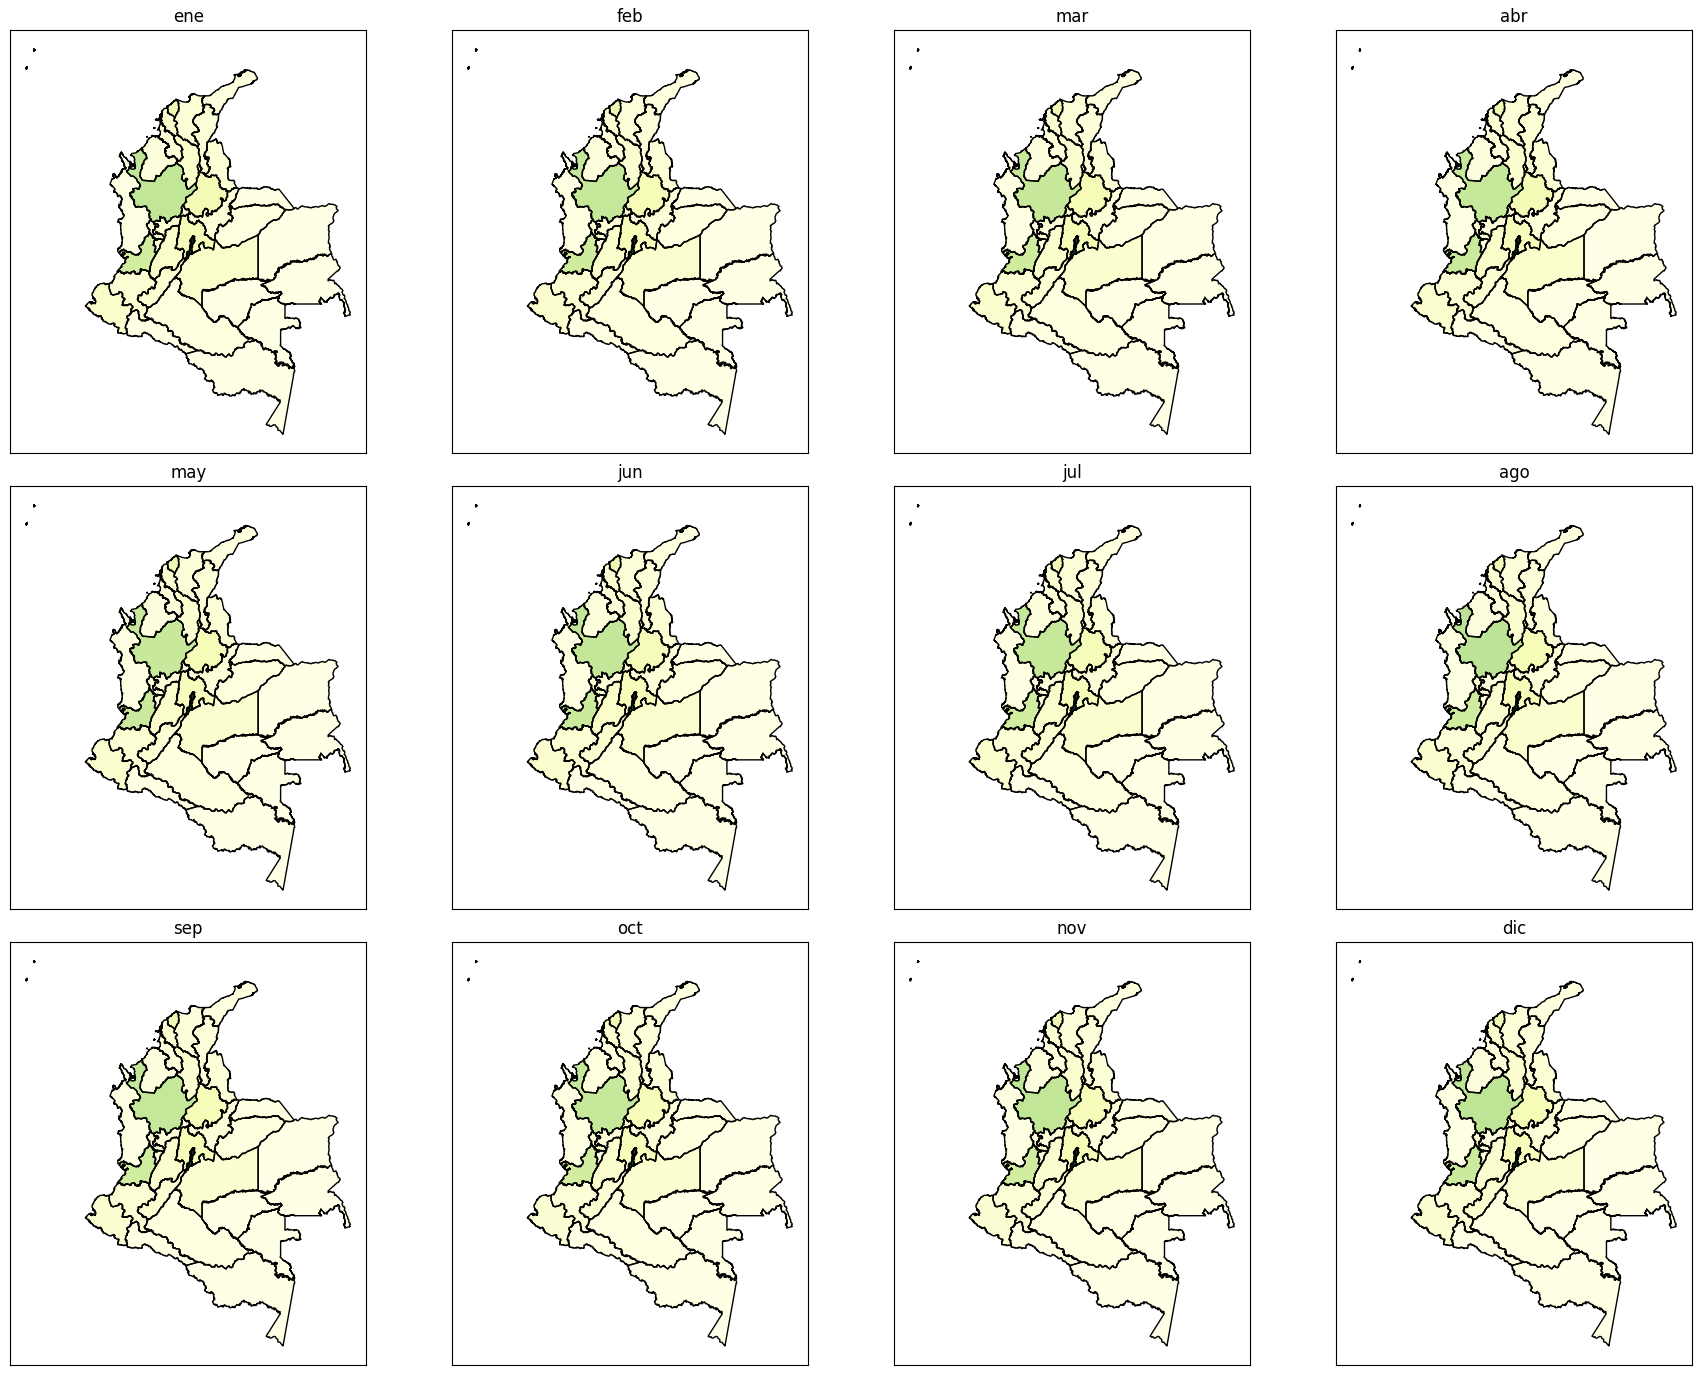

In [90]:
#Distribución espacial de la cantidad absoluta de hurtos
# Obtener la lista de meses (columnas)
meses = Dep_mes.columns[10:]

# Calcular el número de filas y columnas para la matriz de subplots
num_filas = 3
num_columnas = 4
num_graficos = num_filas * num_columnas

# Crear la figura y los subplots
fig, axes = plt.subplots(num_filas, num_columnas, figsize=(18, 15))

# Iterar a través de los meses y los subplots
for i, mes in enumerate(meses):
    fila = i // num_columnas
    columna = i % num_columnas
    ax = axes[fila, columna]

    # Configurar el estilo y plot
    with plt.style.context('seaborn-dark'):
        Dep_mes.plot(column=mes, cmap='YlGn', vmin=Dep_mes[mes].min(), vmax=Dep_mes[mes].max(), ax=ax)

        # Dibujar límites exteriores de los departamentos
        Dep_mes.boundary.plot(ax=ax, linewidth=1, color='black')

        ax.set_title(mes)

    # Quitar etiquetas de ejes
    ax.set_xticks([])
    ax.set_yticks([])

# Ajustar espaciado entre subplots
plt.tight_layout()
plt.subplots_adjust(top=0.9)

plt.show()

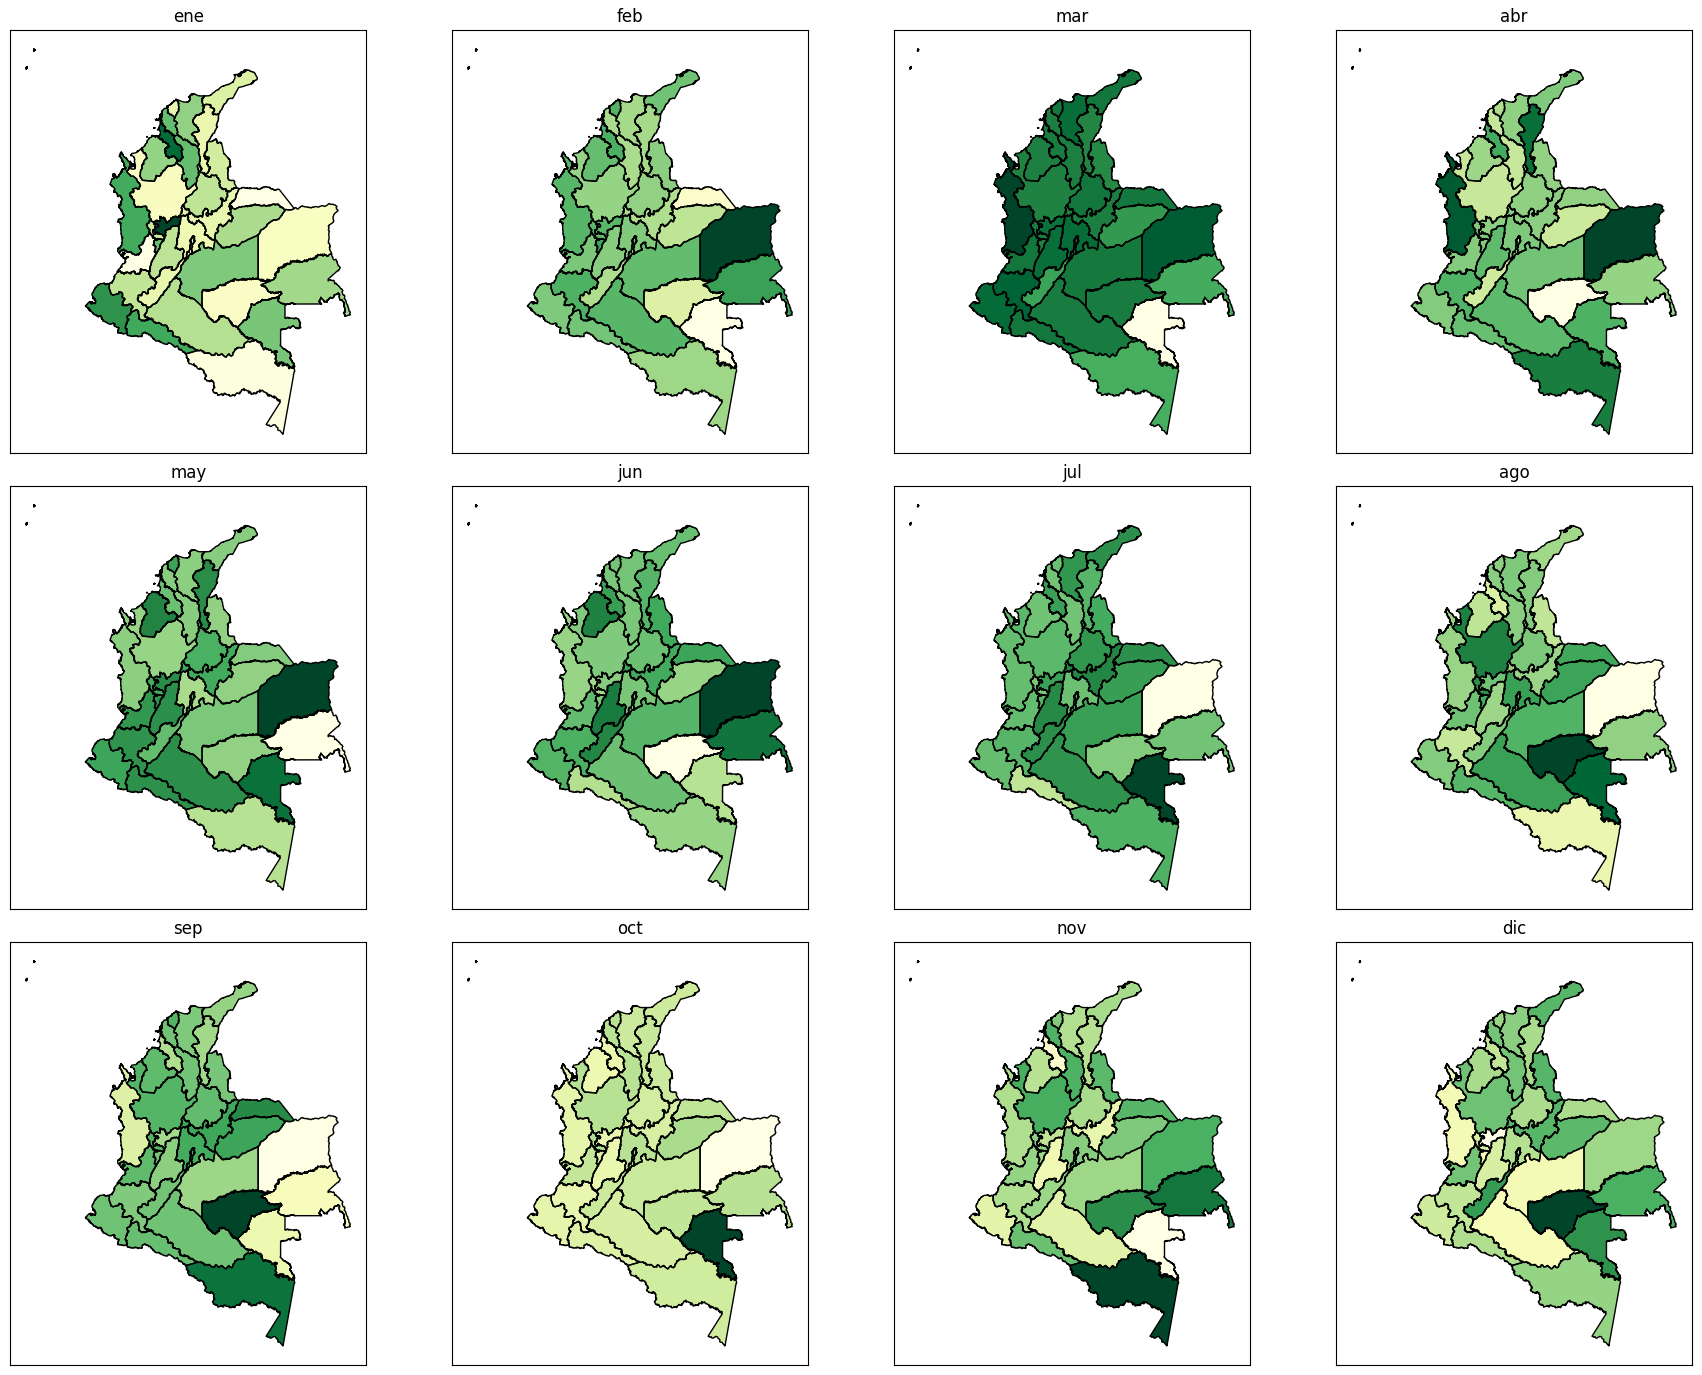

In [91]:
#Distribución espacial de los hurtos estandarizados
# Crear la figura y los subplots
fig, axes = plt.subplots(num_filas, num_columnas, figsize=(18, 15))

# Iterar a través de los meses y los subplots
for i, mes in enumerate(meses):
    fila = i // num_columnas
    columna = i % num_columnas
    ax = axes[fila, columna]

    # Configurar el estilo y plot
    with plt.style.context('seaborn-dark'):
        Dep_mes_por.plot(column=mes, cmap='YlGn', vmin=Dep_mes_por[mes].min(), vmax=Dep_mes_por[mes].max(), ax=ax)

        # Dibujar límites exteriores de los departamentos
        Dep_mes_por.boundary.plot(ax=ax, linewidth=1, color='black')

        ax.set_title(mes)

    # Quitar etiquetas de ejes
    ax.set_xticks([])
    ax.set_yticks([])

# Ajustar espaciado entre subplots
plt.tight_layout()
plt.subplots_adjust(top=0.9)

plt.show()

### Distribución espacial anual del hurto a personas por departamentos.

In [92]:
# Agrupación por departamento y año

tabla_contingencia_dep_ano = tabla_contingencia_dep_ano.reset_index()
tabla_contingencia_dep_ano = tabla_contingencia_dep_ano.rename(columns={'Departamento': 'DPTO_CNMBR'})

tabla_contingencia_dep_ano_por = tabla_contingencia_dep_ano_por.reset_index()
tabla_contingencia_dep_ano_por = tabla_contingencia_dep_ano_por.rename(columns={'Departamento': 'DPTO_CNMBR'})

Dep_ano = Departamentos.merge(tabla_contingencia_dep_ano,on='DPTO_CNMBR',how='inner')
Dep_ano_por = Departamentos.merge(tabla_contingencia_dep_ano_por,on='DPTO_CNMBR',how='inner')

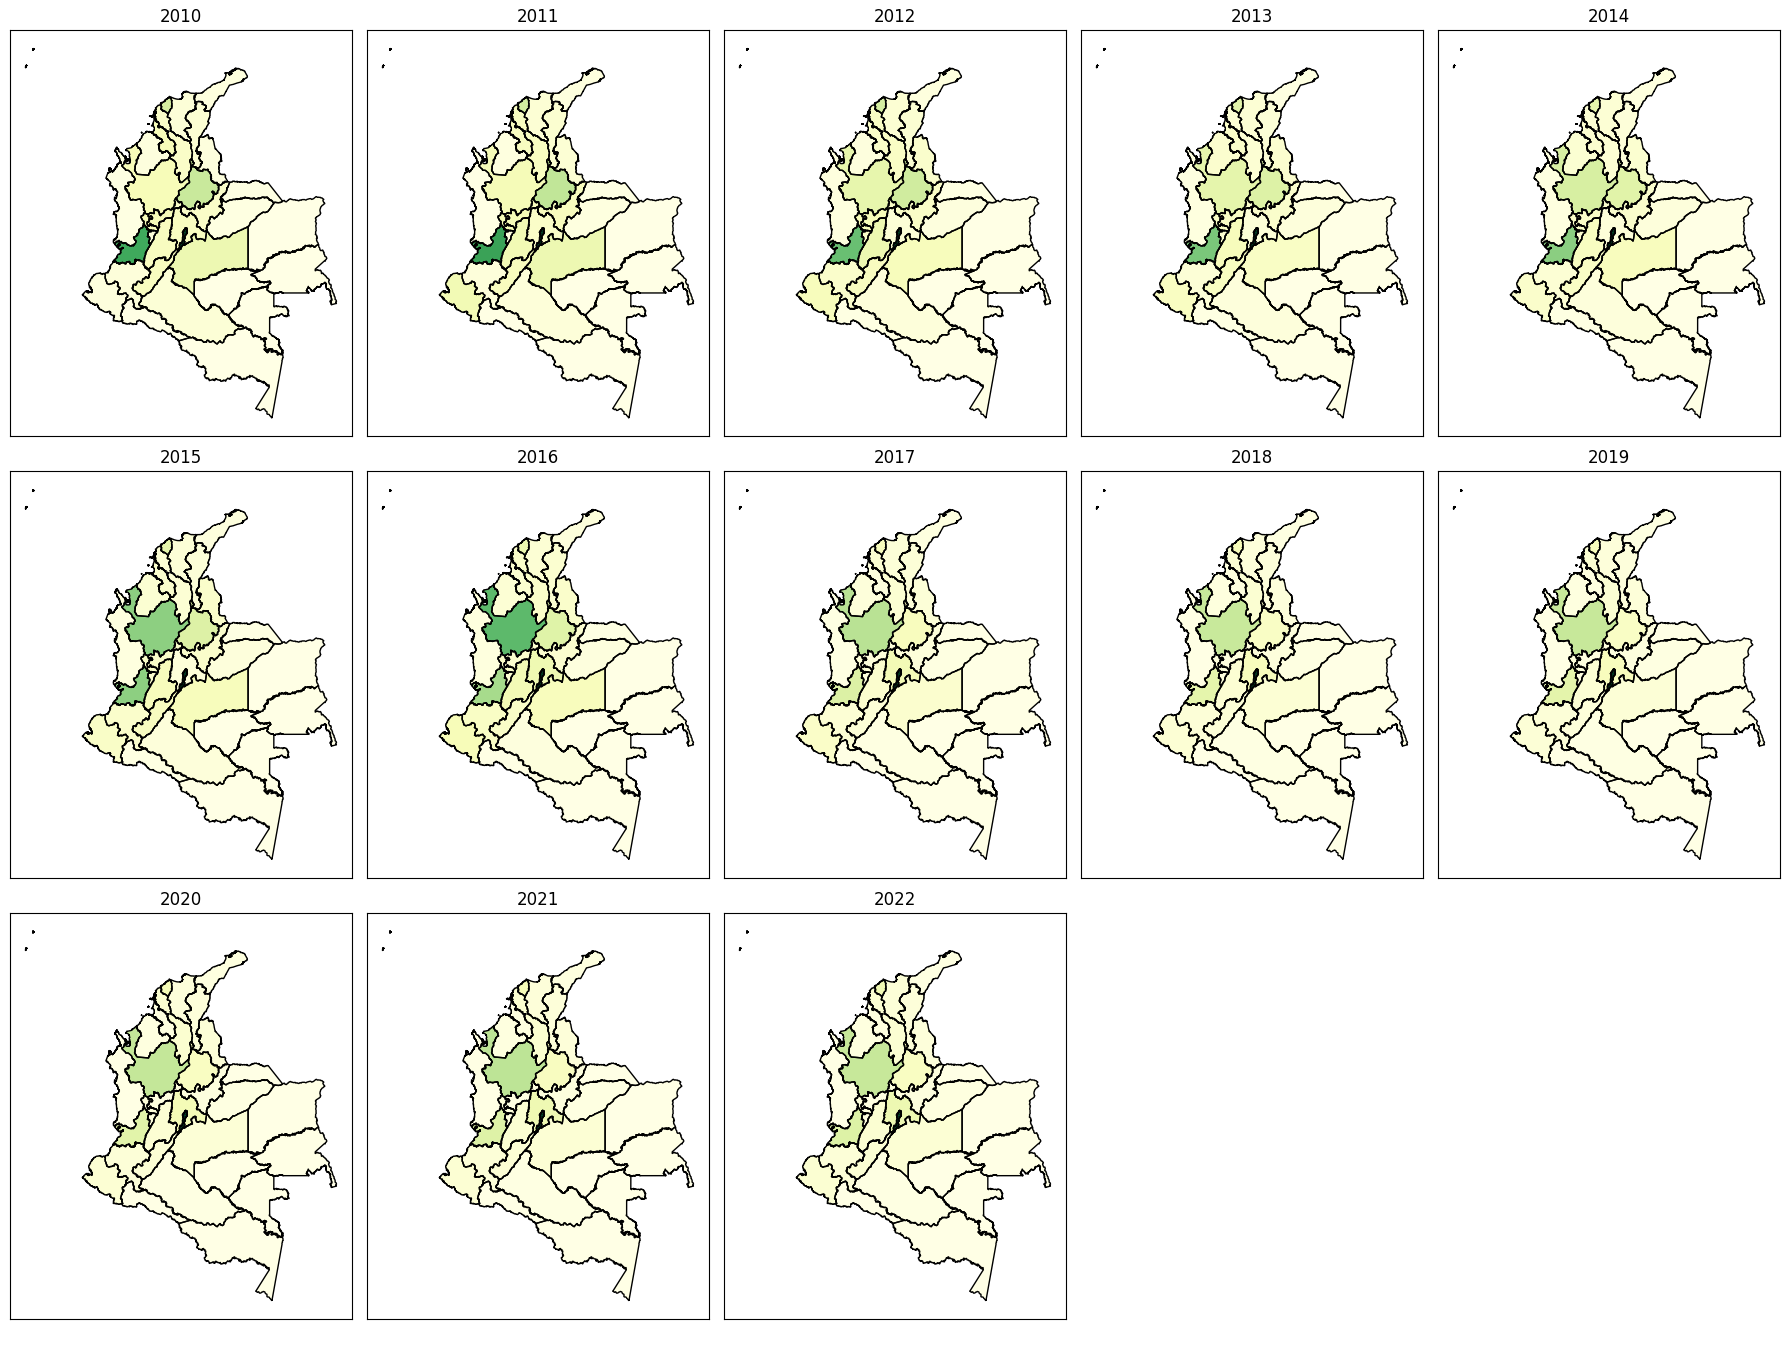

In [93]:
# Obtener la lista de años (columnas)
anos = Dep_ano.columns[10:]

# Calcular el número de filas y columnas para la matriz de subplots
num_filas = 3
num_columnas = 5
num_graficos = num_filas * num_columnas

# Crear la figura y los subplots
fig, axes = plt.subplots(num_filas, num_columnas, figsize=(18, 15))

# Iterar a través de los gráficos en lugar de los meses
for i in range(num_graficos):
    fila = i // num_columnas
    columna = i % num_columnas

    if i < len(anos):  # Solo crear gráficos si quedan años por visualizar
        ax = axes[fila, columna]

        ano = anos[i]

        # Configurar el estilo y plot
        with plt.style.context('seaborn-dark'):
            Dep_ano.plot(column=ano, cmap='YlGn', vmin=Dep_ano[ano].min(), vmax=Dep_ano[ano].max(), ax=ax)

            # Dibujar límites exteriores de los departamentos
            Dep_ano.boundary.plot(ax=ax, linewidth=1, color='black')

            ax.set_title(ano)

        # Quitar etiquetas de ejes
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        axes[fila, columna].axis('off')  # Desactivar ejes para celdas vacías

# Ajustar espaciado entre subplots
plt.tight_layout()
plt.subplots_adjust(top=0.9)

plt.show()

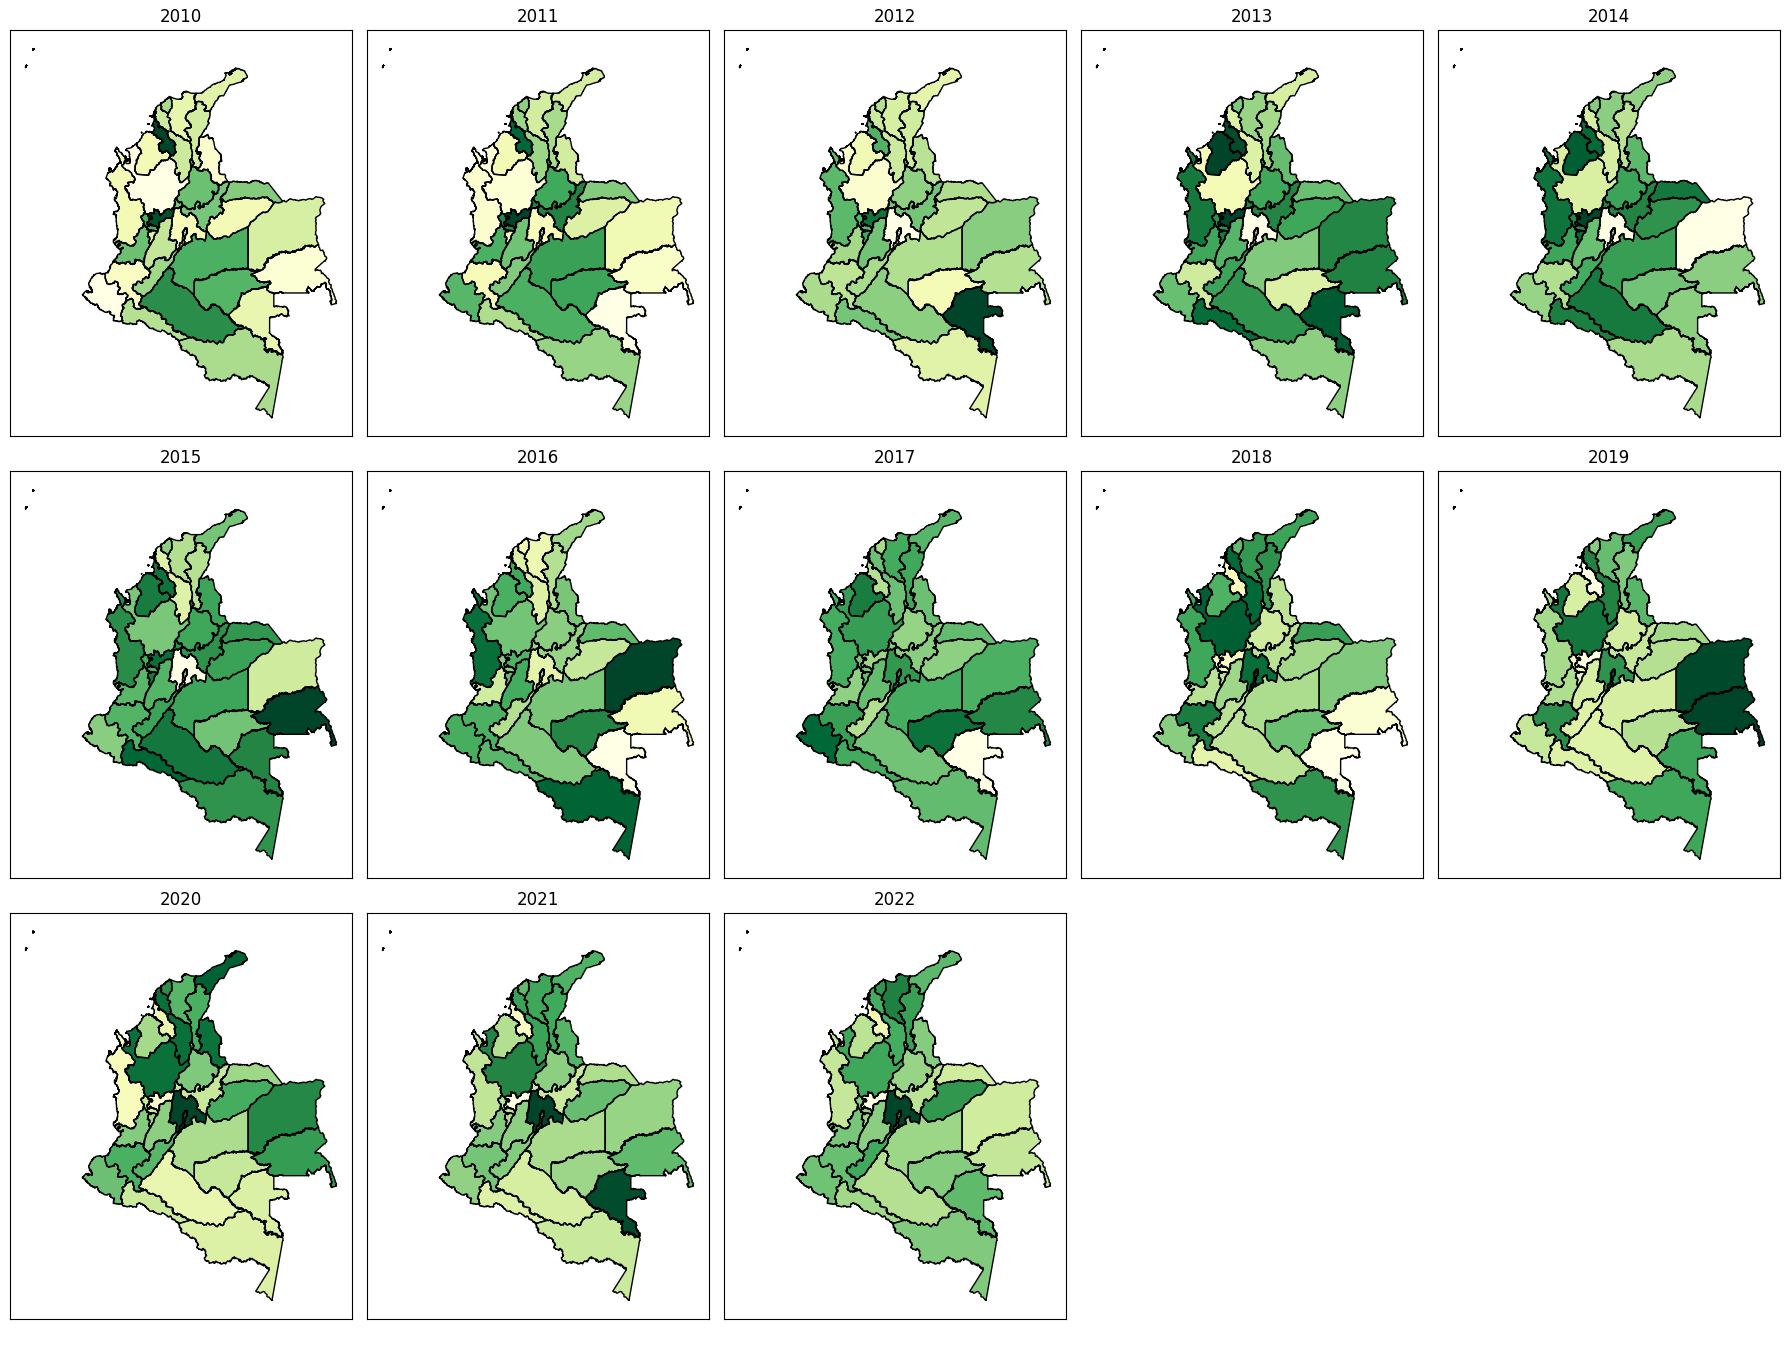

In [95]:
# Crear la figura y los subplots
fig, axes = plt.subplots(num_filas, num_columnas, figsize=(18, 15))

# Iterar a través de los gráficos en lugar de los años
for i in range(num_graficos):
    fila = i // num_columnas
    columna = i % num_columnas

    if i < len(anos):  # Solo crear gráficos si quedan años por visualizar
        ax = axes[fila, columna]

        ano = anos[i]

        # Configurar el estilo y plot
        with plt.style.context('seaborn-dark'):
            Dep_ano_por.plot(column=ano, cmap='YlGn', vmin=Dep_ano_por[ano].min(), vmax=Dep_ano_por[ano].max(), ax=ax)

            # Dibujar límites exteriores de los departamentos
            Dep_ano_por.boundary.plot(ax=ax, linewidth=1, color='black')

            ax.set_title(ano)

        # Quitar etiquetas de ejes
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        axes[fila, columna].axis('off')  # Desactivar ejes para celdas vacías

# Ajustar espaciado entre subplots
plt.tight_layout()
plt.subplots_adjust(top=0.9)

plt.show()


---
# **Autocorrelación**
---

## Autocorrelación mensual por departamento: excluyendo San Andrés (Isla)

In [100]:
#BD departamentos sin San Andrés Islas
Dep_sin_SAI_mes = Dep_mes_por.drop(Dep_mes_por[Dep_mes_por['DPTO_CCDGO'] == '88'].index)

# Matriz de pesos espaciales tipo Reina
wqs = Queen.from_dataframe(Dep_sin_SAI_mes,idVariable='DPTO_CCDGO') # Genere vecindades tipo Reina
wqs.transform = 'r' # Genere pesos espaciales estandarizados por fila
print('Matriz W',wqs)
print('\nproporción enlaces no nulos', "%.3f"%wqs.pct_nonzero,'\n')

Matriz W <libpysal.weights.contiguity.Queen object at 0x7994b9e388e0>

proporción enlaces no nulos 14.453 



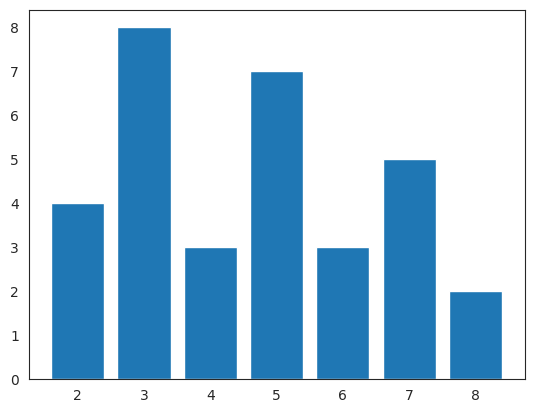

In [97]:
#Histograma de número de vecindades por departamento

with sns.axes_style('white'):
 hist_wqs = np.array(wqs.histogram,ndmin=2)
 plt.bar(hist_wqs[:,0],hist_wqs[:,1])

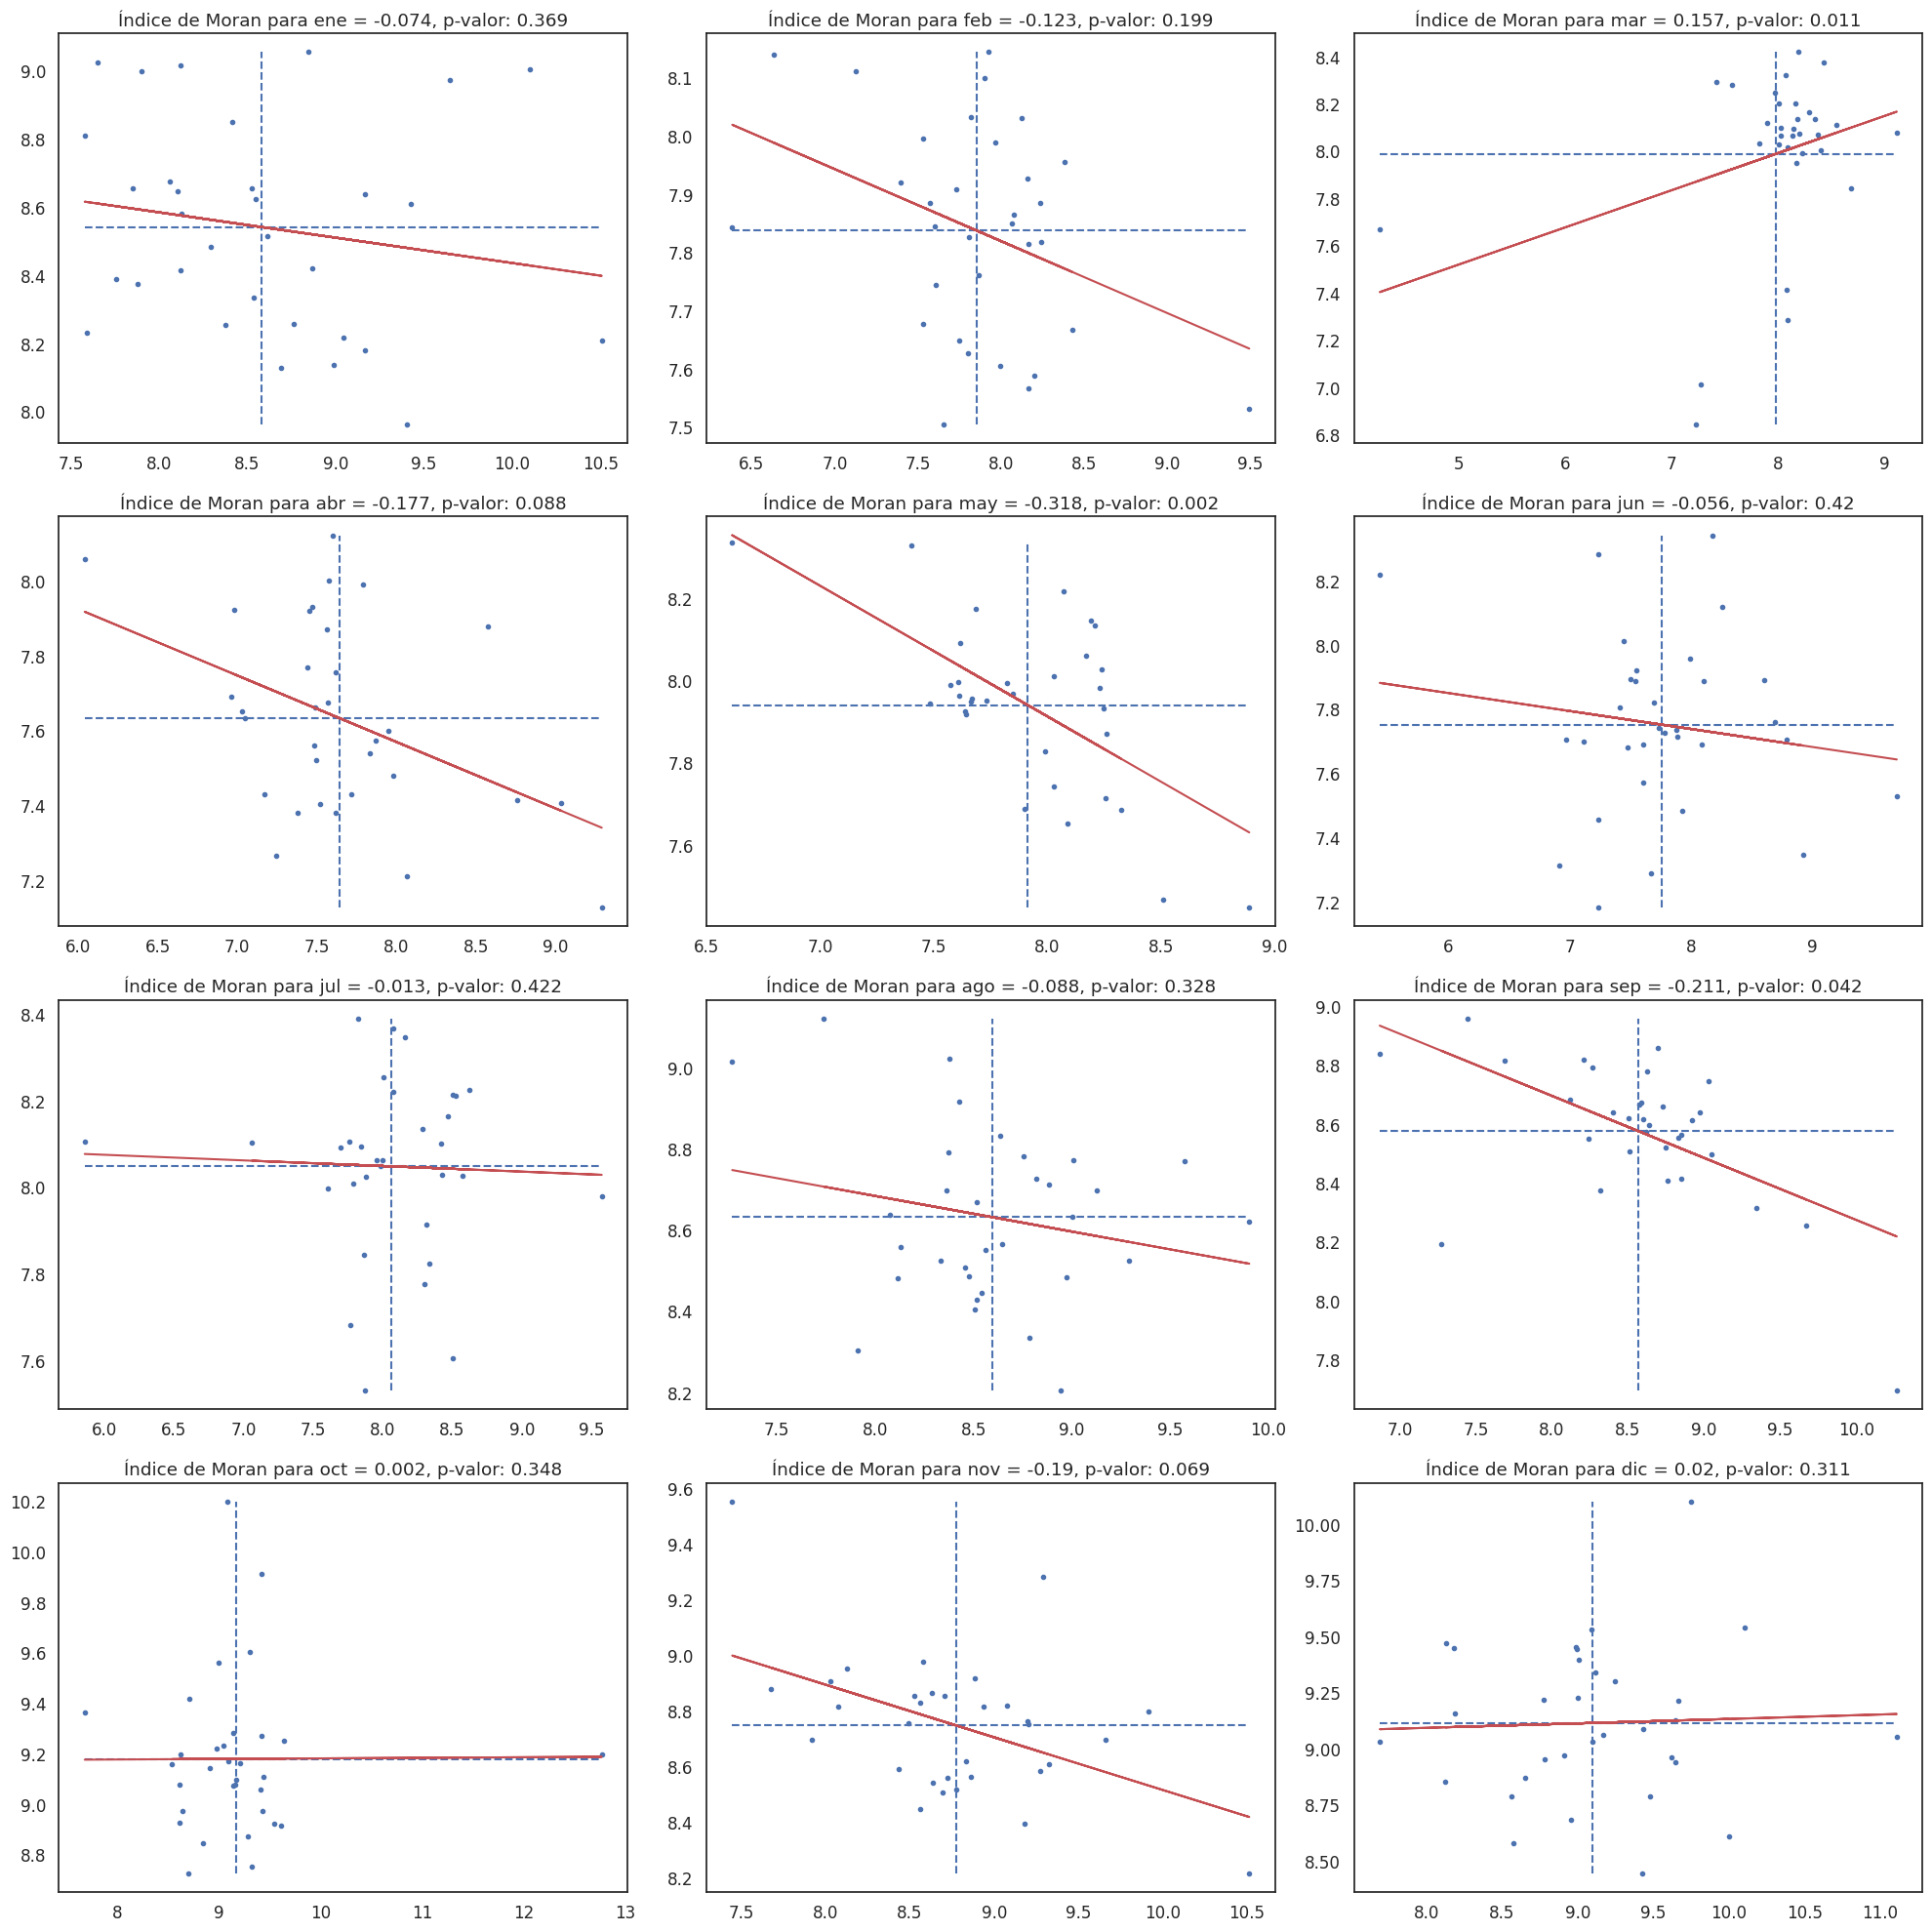

In [101]:
#Rezago espacial por mes
for i, mes in enumerate(Dep_sin_SAI_mes.columns[10:]):
    Dep_sin_SAI_mes['Rezago_' + mes] = weights.lag_spatial(wqs, Dep_sin_SAI_mes[mes])

# Configuración de estilo y tamaño de la figura
sns.set(style='white', palette="deep", font_scale=1.1, rc={"figure.figsize": [20, 20]})

# Crear la matriz de subplots 4x3
fig, axes = plt.subplots(4, 3)

# Iterar sobre las columnas seleccionadas
for i, mes in enumerate(Dep_sin_SAI_mes.columns[10:22]):
    b, a = np.polyfit(Dep_sin_SAI_mes[mes], Dep_sin_SAI_mes['Rezago_'+mes], 1)
    indice = Moran(Dep_sin_SAI_mes[mes].fillna(100),wqs, permutations=10000)

    # Graficar el diagrama de dispersión
    axes[i//3, i%3].plot(Dep_sin_SAI_mes[mes], Dep_sin_SAI_mes['Rezago_'+mes], '.')

    # Línea vertical punteada en la media de la columna 'mes'
    axes[i//3, i%3].vlines(Dep_sin_SAI_mes[mes].mean(), Dep_sin_SAI_mes['Rezago_'+mes].min(), Dep_sin_SAI_mes['Rezago_'+mes].max(), linestyle='--')

    # Línea horizontal punteada en la media de la columna 'Rezago_mes'
    axes[i//3, i%3].hlines(Dep_sin_SAI_mes['Rezago_'+mes].mean(), Dep_sin_SAI_mes[mes].min(), Dep_sin_SAI_mes[mes].max(), linestyle='--')

    # Línea roja de mejor ajuste utilizando el valor de 'b' como pendiente
    axes[i//3, i%3].plot(Dep_sin_SAI_mes[mes], a + b*Dep_sin_SAI_mes[mes], 'r')
    indice = Moran(Dep_sin_SAI_mes[mes].fillna(100),wqs, permutations=10000)
    # Título del subplot
    axes[i//3, i%3].set_title('Índice de Moran para '+mes+ ' = '+ str(round(indice.I, 3))+ ', p-valor: '+str(round(indice.p_sim,3)))

# Ajustar los espacios entre los subplots y mostrar la figura
plt.tight_layout()
plt.show()

## Autocorrelación anual por departamento: excluyendo San Andrés (Isla)

In [102]:
#BD departamentos sin San Andrés Islas
Dep_sin_SAI_ano = Dep_ano_por.drop(Dep_ano_por[Dep_ano_por['DPTO_CCDGO'] == '88'].index)

# Matriz de pesos espaciales tipo Reina
wqs = Queen.from_dataframe(Dep_sin_SAI_ano,idVariable='DPTO_CCDGO') # Genere vecindades tipo Reina
wqs.transform = 'r' # Genere pesos espaciales estandarizados por fila
print('Matriz W',wqs)
print('\nproporción enlaces no nulos', "%.3f"%wqs.pct_nonzero,'\n')

Matriz W <libpysal.weights.contiguity.Queen object at 0x7994b8cf5210>

proporción enlaces no nulos 14.453 



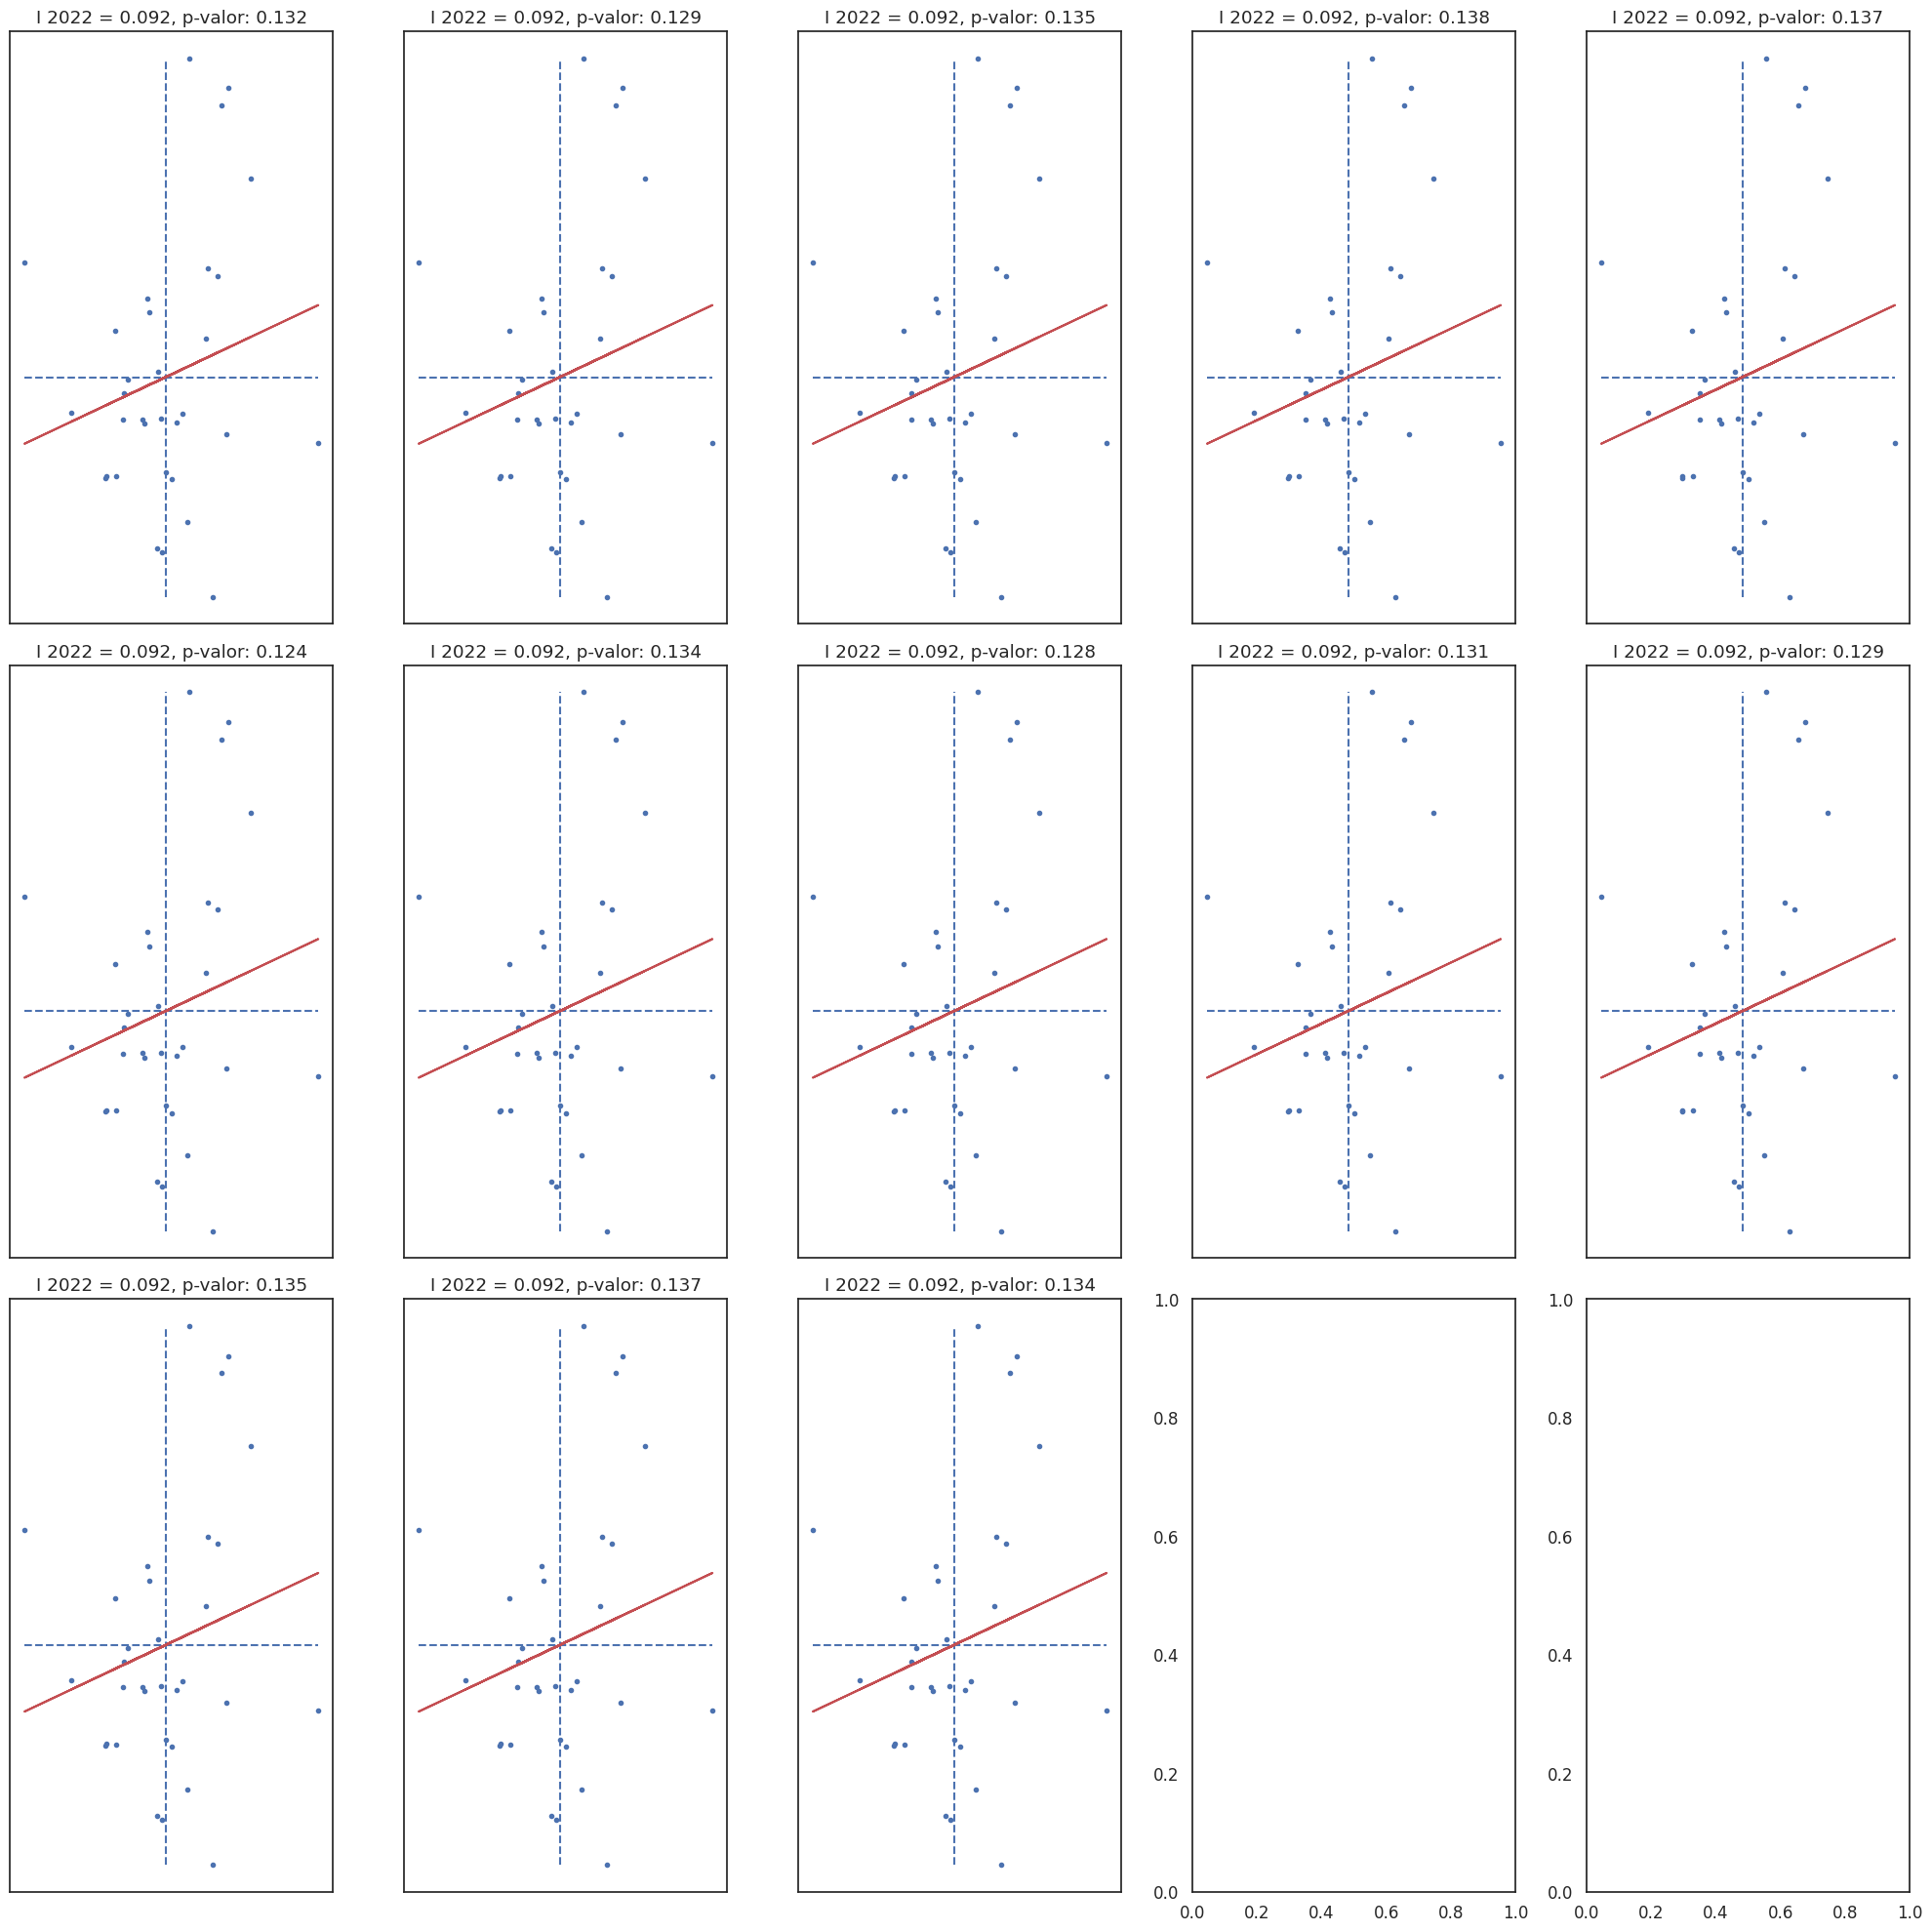

In [103]:
#Rezago espacial por año
for i, ano in enumerate(Dep_sin_SAI_ano.columns[10:]):
    Dep_sin_SAI_ano['Rezago_' + str(ano)] = weights.lag_spatial(wqs, Dep_sin_SAI_ano[ano])

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from esda.moran import Moran  # Asumiendo que estás usando esto

# Obtener las columnas seleccionadas
selected_columns = Dep_sin_SAI_ano.columns[10:23]

# Configuración de estilo y tamaño de la figura
sns.set(style='white', palette="deep", font_scale=1.1, rc={"figure.figsize": [20, 20]})

# Calcular el número de filas y columnas para la matriz de subplots
num_filas = 3
num_columnas = 5
num_graficos = 13

# Crear la matriz de subplots
fig, axes = plt.subplots(num_filas, num_columnas)

# Iterar sobre las columnas seleccionadas y los subplots
for i in range(num_graficos):
    fila = i // num_columnas
    columna = i % num_columnas

    if i < num_graficos:  # Solo crear gráficos si quedan columnas por visualizar
        b, a = np.polyfit(Dep_sin_SAI_ano[ano], Dep_sin_SAI_ano['Rezago_'+ str(ano)], 1)
        indice = Moran(Dep_sin_SAI_ano[ano].fillna(100), wqs, permutations=10000)

        ax = axes[fila, columna]

        # Graficar el diagrama de dispersión
        ax.plot(Dep_sin_SAI_ano[ano], Dep_sin_SAI_ano['Rezago_'+ str(ano)], '.')

        # Línea vertical punteada en la media de la columna 'ano'
        ax.vlines(Dep_sin_SAI_ano[ano].mean(), Dep_sin_SAI_ano['Rezago_'+ str(ano)].min(), Dep_sin_SAI_ano['Rezago_'+ str(ano)].max(), linestyle='--')

        # Línea horizontal punteada en la media de la columna 'Rezago_ano'
        ax.hlines(Dep_sin_SAI_ano['Rezago_'+ str(ano)].mean(), Dep_sin_SAI_ano[ano].min(), Dep_sin_SAI_ano[ano].max(), linestyle='--')

        # Línea roja de mejor ajuste utilizando el valor de 'b' como pendiente
        ax.plot(Dep_sin_SAI_ano[ano], a + b*Dep_sin_SAI_ano[ano], 'r')

        # Título del subplot
        ax.set_title('I '+str(ano)+ ' = '+ str(round(indice.I, 3))+ ', p-valor: '+str(round(indice.p_sim,3)))

        # Quitar etiquetas de ejes
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        axes[fila, columna].axis('off')  # Desactivar ejes para celdas vacías

# Ajustar los espacios entre los subplots y mostrar la figura
plt.tight_layout()
plt.show()

## Distribución espacial por Municipios de algunos departamentos en el mes de marzo

In [104]:
#Enlace para descargar el shape de los departamentos y municipios de Colombia

# https://drive.google.com/file/d/10ECRJbtbyjClG6PC3JsYdmcr5jqFmmEn/view?usp=sharing

!wget 'https://drive.google.com/uc?export=download&id=10ECRJbtbyjClG6PC3JsYdmcr5jqFmmEn' -O colMun.zip

!unzip colMun.zip

Municipios = gpd.read_file('colMun.shp')
Municipios.columns.values

--2023-08-19 21:36:42--  https://drive.google.com/uc?export=download&id=10ECRJbtbyjClG6PC3JsYdmcr5jqFmmEn
Resolving drive.google.com (drive.google.com)... 142.251.163.101, 142.251.163.139, 142.251.163.138, ...
Connecting to drive.google.com (drive.google.com)|142.251.163.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-1g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/k38olf8if14s673c3hd343c0d0d30m36/1692480975000/12653930227734307627/*/10ECRJbtbyjClG6PC3JsYdmcr5jqFmmEn?e=download&uuid=8345123e-1762-44b2-a0f5-2537c5696fb8 [following]
--2023-08-19 21:36:44--  https://doc-0g-1g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/k38olf8if14s673c3hd343c0d0d30m36/1692480975000/12653930227734307627/*/10ECRJbtbyjClG6PC3JsYdmcr5jqFmmEn?e=download&uuid=8345123e-1762-44b2-a0f5-2537c5696fb8
Resolving doc-0g-1g-docs.googleusercontent.com (doc-0g-1g-docs.googleusercontent.com)... 142.251.163.132, 

array(['OBJECTID', 'codigo', 'AREA_OFICI', 'ENTIDAD_TE', 'NOM_DEPART',
       'NOM_MUNICI', 'COD_DEPTO', 'SHAPE_area', 'SHAPE_len', 'DIVIPOLA',
       'geometry'], dtype=object)

In [105]:
#Lista de los departamentos del Shape
Municipios['NOM_DEPART'].unique()

array(['CÓRDOBA', 'SUCRE', 'BOLÍVAR', 'ATLANTICO', 'AMAZONAS', 'GUAVIARE',
       'VAUPES', 'GUAINIA', 'VICHADA', 'META', 'CASANARE', 'BOYACÁ',
       'ARAUCA', 'LA GUAJIRA', 'MAGDALENA', 'CESAR', 'NORTE DE SANTANDER',
       'SANTANDER', 'CUNDINAMARCA', 'SATA FE DE BOGOTÁ D.C.', 'CHOCÓ',
       'CAUCA', 'NN', 'VALLE DEL CAUCA', 'NARIÑO', 'PUTUMAYO', 'CAQUETÁ',
       'HUILA', 'TOLIMA', 'QUINDIO', 'RISARALDA', 'CALDAS', 'ANTIOQUIA',
       'ARCHIPIÉLAGO DE SAN ANDRÉS, PROVIDENCIA Y SANTA CATALINA'],
      dtype=object)

In [106]:
#Ajuste de los nombres de los departamentos de acuerdo con la base de datos utilizada
Municipios['NOM_DEPART'] = Municipios['NOM_DEPART'].replace('ATLANTICO', 'ATLÁNTICO')
Municipios['NOM_DEPART'] = Municipios['NOM_DEPART'].replace('SATA FE DE BOGOTÁ D.C.', 'BOGOTÁ D.C.')
Municipios['NOM_DEPART'] = Municipios['NOM_DEPART'].replace('QUINDIO', 'QUINDÍO')
Municipios['NOM_DEPART'] = Municipios['NOM_DEPART'].replace('VALLE DEL CAUCA', 'VALLE')
Municipios['NOM_DEPART'] = Municipios['NOM_DEPART'].replace('ARCHIPIÉLAGO DE SAN ANDRÉS, PROVIDENCIA Y SANTA CATALINA', 'SAN ANDRÉS')
Municipios['NOM_DEPART'] = Municipios['NOM_DEPART'].replace('GUAINIA', 'GUAINÍA')
Municipios['NOM_DEPART'] = Municipios['NOM_DEPART'].replace('VAUPES', 'VAUPÉS')

In [116]:
#Ajuste de los nombres de algunos municipios de acuerdo con la base de datos utilizada

Municipios['NOM_MUNICI'] = Municipios['NOM_MUNICI'].replace('CARURÚ', 'CARURU')
Municipios['NOM_MUNICI'] = Municipios['NOM_MUNICI'].replace('MITÚ', 'MITÚ (CT)')
Municipios['NOM_MUNICI'] = Municipios['NOM_MUNICI'].replace('SAN JOSÉ DEL GUAVIARE', 'SAN JOSÉ DEL GUAVIARE (CT)')
Municipios['NOM_MUNICI'] = Municipios['NOM_MUNICI'].replace('LETICIA', 'LETICIA (CT)')
Municipios['NOM_MUNICI'] = Municipios['NOM_MUNICI'].replace('PUERTO CARREÑO', 'PUERTO CARREÑO (CT))')
Municipios['NOM_MUNICI'] = Municipios['NOM_MUNICI'].replace('INIRIDA', 'INÍRIDA (CT)')
Municipios['NOM_MUNICI'] = Municipios['NOM_MUNICI'].replace('ARAUCA', 'ARAUCA (CT)')
Municipios['NOM_MUNICI'] = Municipios['NOM_MUNICI'].replace('BOJAYÁ (Bellavista)', 'BOJAYÁ')
Municipios['NOM_MUNICI'] = Municipios['NOM_MUNICI'].replace('MEDIO SAN JUAN (Andagoya)', 'MEDIO SAN JUAN')
Municipios['NOM_MUNICI'] = Municipios['NOM_MUNICI'].replace('CERTEGUI', 'CÉRTEGUI')
Municipios['NOM_MUNICI'] = Municipios['NOM_MUNICI'].replace('RÍO QUITO (Paimadó)', 'RÍO QUITO')
Municipios['NOM_MUNICI'] = Municipios['NOM_MUNICI'].replace('EL CARMEN', 'EL CARMEN DE ATRATO')
Municipios['NOM_MUNICI'] = Municipios['NOM_MUNICI'].replace('MEDIO BAUDÓ (Boca de Pepé)', 'MEDIO BAUDÓ')
Municipios['NOM_MUNICI'] = Municipios['NOM_MUNICI'].replace('RÍO IRÓ (Santa Rita)', 'RÍO IRO')
Municipios['NOM_MUNICI'] = Municipios['NOM_MUNICI'].replace('ATRATO (Yuto)', 'ATRATO')
Municipios['NOM_MUNICI'] = Municipios['NOM_MUNICI'].replace('UNIÓN PANAMERICANA (Ánimas)', 'UNIÓN PANAMERICANA')
Municipios['NOM_MUNICI'] = Municipios['NOM_MUNICI'].replace('MEDIO ATRATO (Beté)', 'MEDIO ATRATO')
Municipios['NOM_MUNICI'] = Municipios['NOM_MUNICI'].replace('BAJO BAUDÓ  (Pizarro)', 'BAJO BAUDÓ')
Municipios['NOM_MUNICI'] = Municipios['NOM_MUNICI'].replace('ALTO BAUDÓ (Pie de Pató)', 'ALTO BAUDÓ')
Municipios['NOM_MUNICI'] = Municipios['NOM_MUNICI'].replace('QUIBDÓ', 'QUIBDÓ (CT)')
Municipios['NOM_MUNICI'] = Municipios['NOM_MUNICI'].replace('BAHÍA SOLANO (Mutis)', 'BAHÍA SOLANO')
Municipios['NOM_MUNICI'] = Municipios['NOM_MUNICI'].replace('CARMEN DEL DARIÉN  (Curbaradó)', 'CARMEN DEL DARIEN')
Municipios['NOM_MUNICI'] = Municipios['NOM_MUNICI'].replace('TORIBÍO', 'TORIBIO')
Municipios['NOM_MUNICI'] = Municipios['NOM_MUNICI'].replace('POPAYÁN', 'POPAYÁN (CT)')
Municipios['NOM_MUNICI'] = Municipios['NOM_MUNICI'].replace('PATÍA  (El Bordo)', 'PATÍA')
Municipios['NOM_MUNICI'] = Municipios['NOM_MUNICI'].replace('SOTARÁ (Paispamba)', 'SOTARA')
Municipios['NOM_MUNICI'] = Municipios['NOM_MUNICI'].replace('PURACÉ (Coconuco)', 'PURACÉ')
Municipios['NOM_MUNICI'] = Municipios['NOM_MUNICI'].replace('PÁEZ (Belalcázar)', 'PAEZ')
Municipios['NOM_MUNICI'] = Municipios['NOM_MUNICI'].replace('MONTERÍA', 'MONTERÍA (CT)')
Municipios['NOM_MUNICI'] = Municipios['NOM_MUNICI'].replace('SAN ANDRÉS DE SOTAVENTO', 'SAN ANDRÉS SOTAVENTO')
Municipios['NOM_MUNICI'] = Municipios['NOM_MUNICI'].replace('SAN JUAN DE RIOSECO', 'SAN JUAN DE RÍO SECO')
Municipios['NOM_MUNICI'] = Municipios['NOM_MUNICI'].replace('FÓMEQUE', 'FOMEQUE')
Municipios['NOM_MUNICI'] = Municipios['NOM_MUNICI'].replace('CÁQUEZA', 'CAQUEZA')
Municipios['NOM_MUNICI'] = Municipios['NOM_MUNICI'].replace('MACHETÁ', 'MACHETA')
Municipios['NOM_MUNICI'] = Municipios['NOM_MUNICI'].replace('GUAYABAL DE SÍQUIMA', 'GUAYABAL DE SIQUIMA')
Municipios['NOM_MUNICI'] = Municipios['NOM_MUNICI'].replace('GACHALÁ', 'GACHALA')

In [117]:
#Agrupación por municipio, mes y porcentajede hurto
tabla_grupo_mun_mes = df.groupby(['Municipio', 'Mes'])['Cantidad'].sum().reset_index()
tabla_grupo_mun_mes['Porcentaje'] = tabla_grupo_mun_mes.groupby('Municipio')['Cantidad'].transform(lambda x: x / x.sum() * 100)

tabla_contingencia_mun_mes = pd.DataFrame(tabla_grupo_mun_mes.pivot(index='Municipio', columns='Mes', values='Porcentaje'))
tabla_contingencia_mun_mes = tabla_contingencia_mun_mes.reset_index()
tabla_contingencia_mun_mes = tabla_contingencia_mun_mes.rename(columns={'Municipio': 'NOM_MUNICI'})

# Definir el orden de los meses
orden_meses_mun = ['NOM_MUNICI', 'ene', 'feb', 'mar', 'abr', 'may', 'jun', 'jul', 'ago', 'sep', 'oct', 'nov', 'dic']

# Reorganizar las columnas en el orden deseado
tabla_contingencia_mun_mes = tabla_contingencia_mun_mes.reindex(columns=orden_meses_mun)

#Combinación de dataframes de municipio y rellenar vacíos con cero.
Mun = Municipios.merge(tabla_contingencia_mun_mes, on='NOM_MUNICI', how='left')
Mun = Mun.fillna(0)

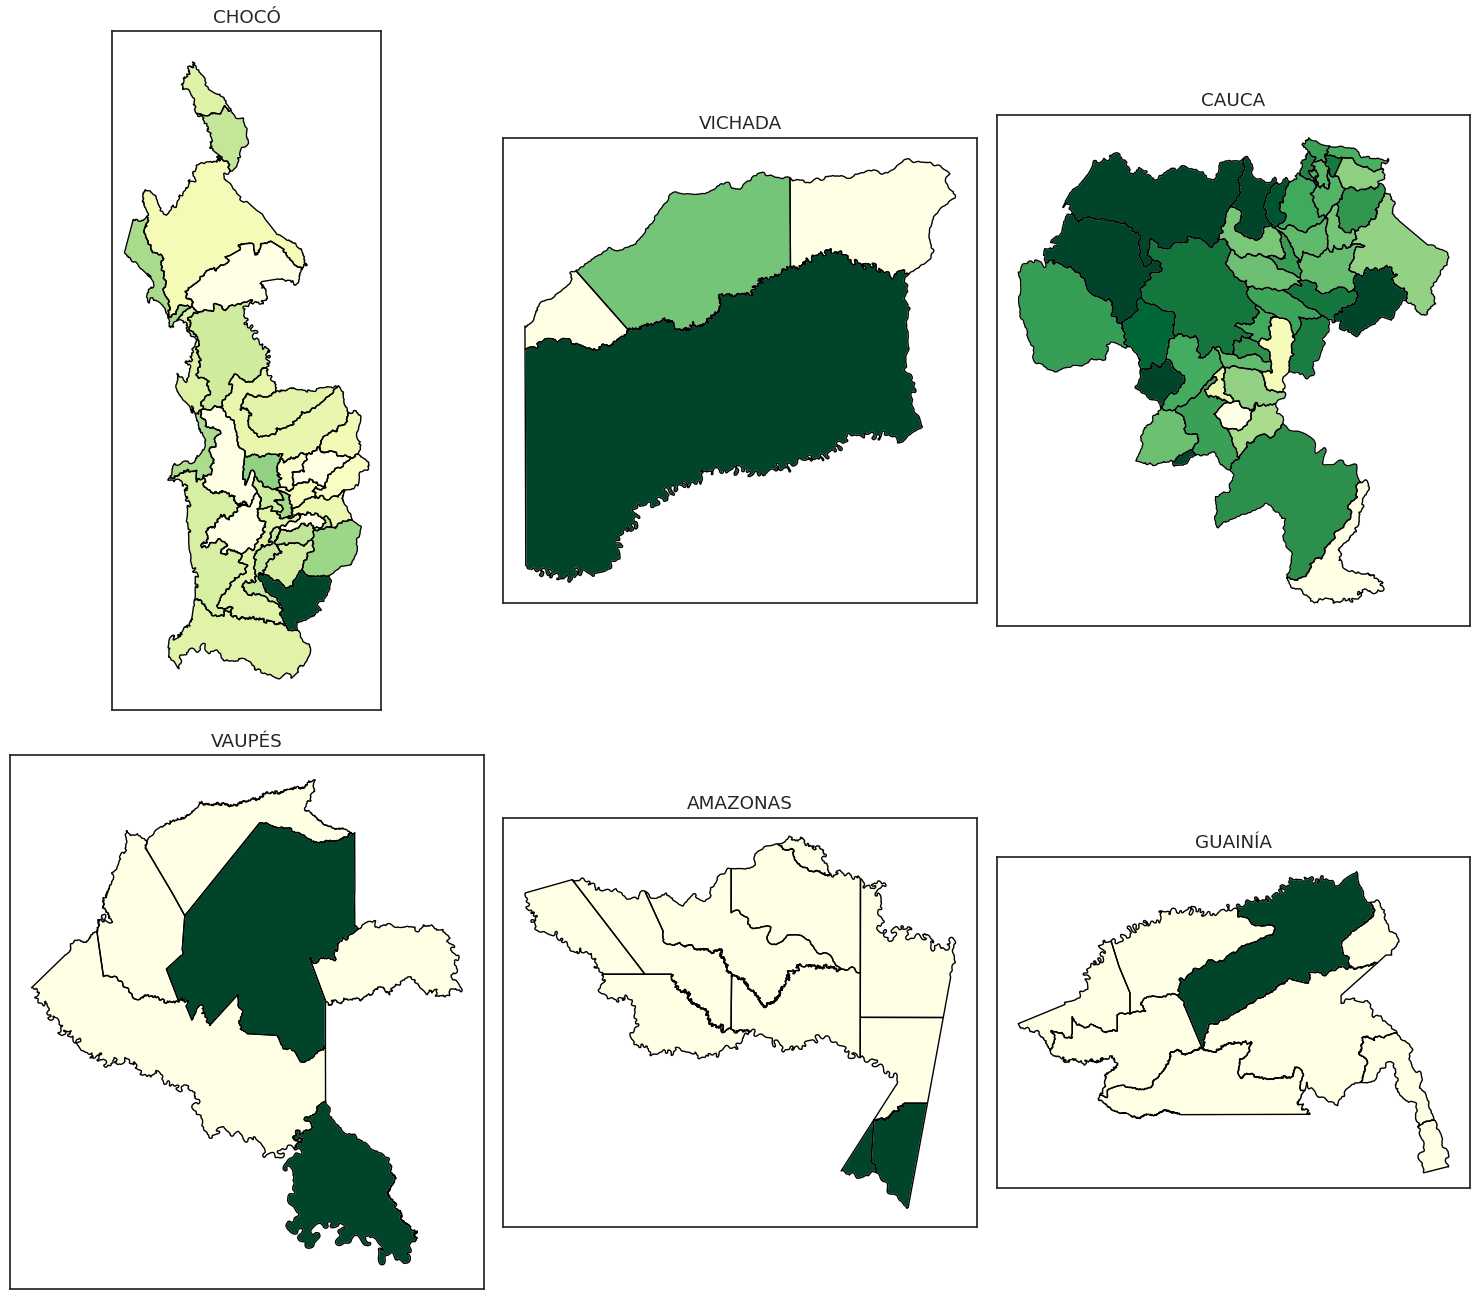

In [118]:
# Obtener la lista de meses (columnas)
departamentos_deseados = ['CHOCÓ', 'VICHADA', 'CAUCA', 'VAUPÉS', 'AMAZONAS', 'GUAINÍA']

# Calcular el número de filas y columnas para la matriz de subplots
num_filas = 2
num_columnas = 3
num_graficos = num_filas * num_columnas

# Crear la figura y los subplots
fig, axes = plt.subplots(num_filas, num_columnas, figsize=(15, 15))

# Iterar a través de los meses y los subplots
for i, dep in enumerate(departamentos_deseados):
    fila = i // num_columnas
    columna = i % num_columnas
    ax = axes[fila, columna]
    Departamento = Mun.loc[Mun['NOM_DEPART'] == dep]

    # Configurar el estilo y plot
    with plt.style.context('seaborn-dark'):
        Departamento.plot(column='sep', cmap='YlGn', vmin=0, vmax=Departamento['mar'].max(), ax=ax)

        # Dibujar límites exteriores de los departamentos
        Departamento.boundary.plot(ax=ax, linewidth=1, color='black')

        ax.set_title(dep)

    # Quitar etiquetas de ejes
    ax.set_xticks([])
    ax.set_yticks([])

# Ajustar espaciado entre subplots
plt.tight_layout()
plt.subplots_adjust(top=0.9)

plt.show()

## Distribución espacial por Municipios de algunos departamentos en el mes de mayo

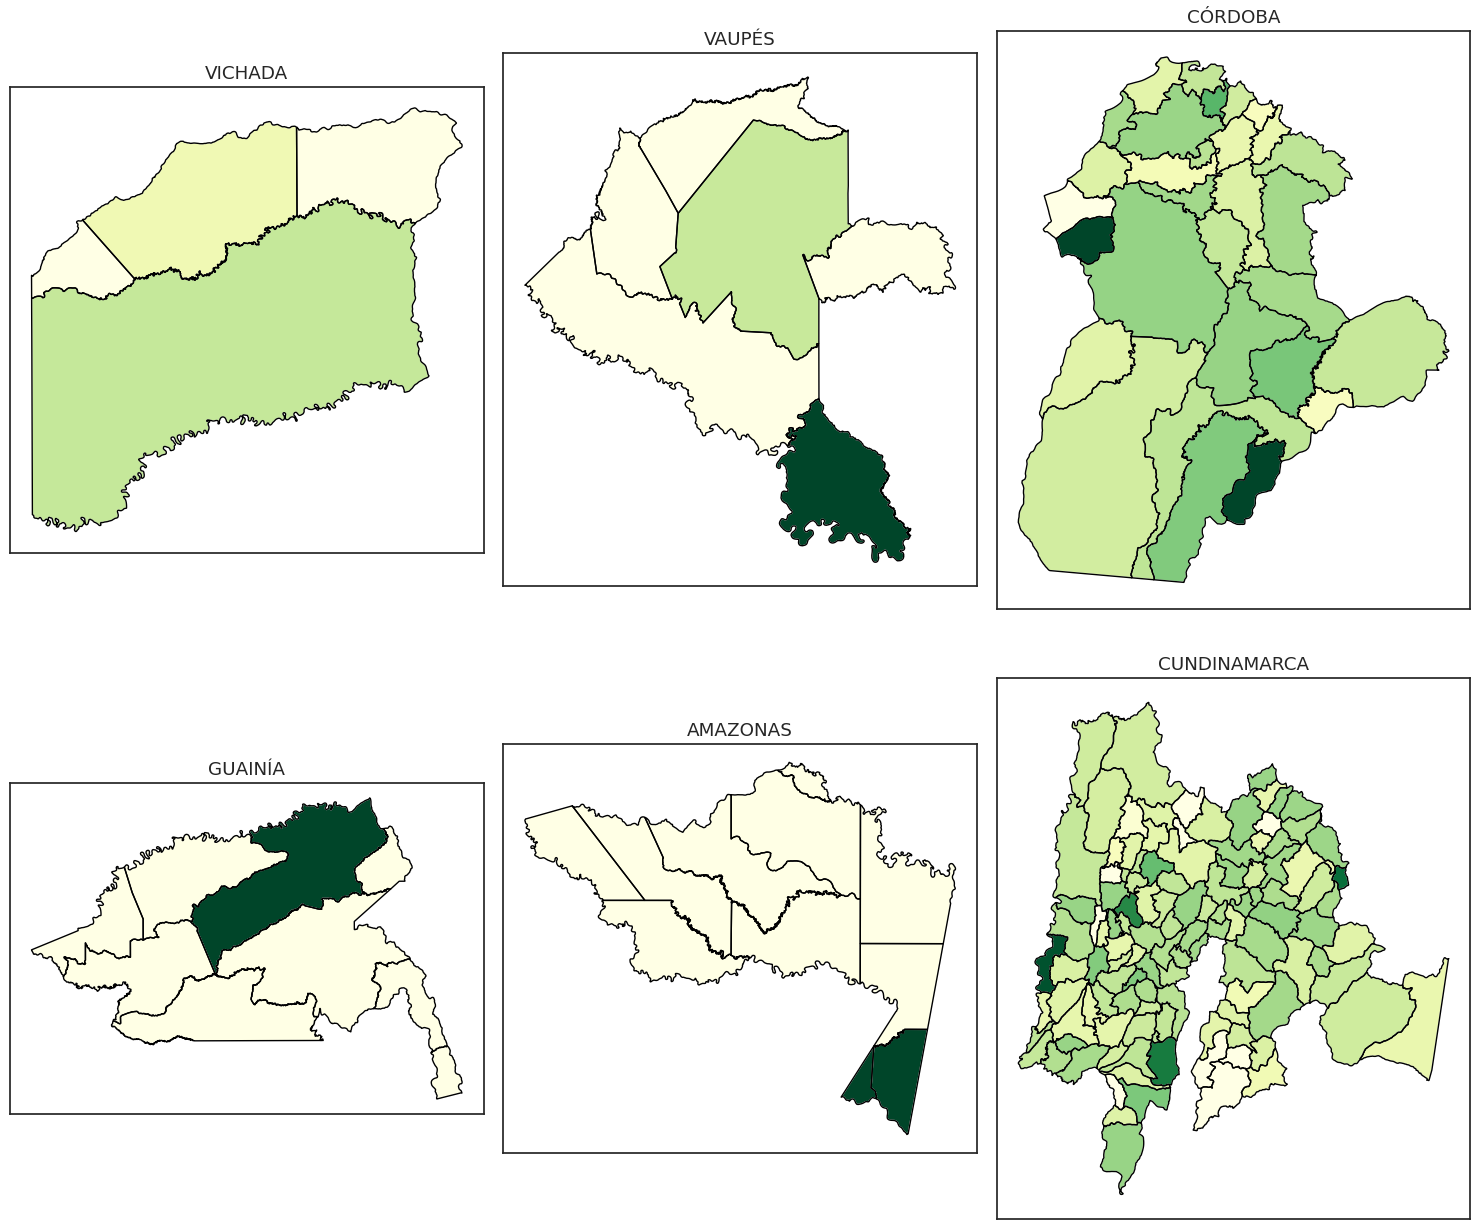

In [119]:
# Obtener la lista de meses (columnas)
departamentos_deseados = ['VICHADA', 'VAUPÉS', 'CÓRDOBA', 'GUAINÍA', 'AMAZONAS', 'CUNDINAMARCA']

# Calcular el número de filas y columnas para la matriz de subplots
num_filas = 2
num_columnas = 3
num_graficos = num_filas * num_columnas

# Crear la figura y los subplots
fig, axes = plt.subplots(num_filas, num_columnas, figsize=(15, 15))

# Iterar a través de los meses y los subplots
for i, dep in enumerate(departamentos_deseados):
    fila = i // num_columnas
    columna = i % num_columnas
    ax = axes[fila, columna]
    Departamento = Mun.loc[Mun['NOM_DEPART'] == dep]

    # Configurar el estilo y plot
    with plt.style.context('seaborn-dark'):
        Departamento.plot(column='sep', cmap='YlGn', vmin=0, vmax=Departamento['may'].max(), ax=ax)

        # Dibujar límites exteriores de los departamentos
        Departamento.boundary.plot(ax=ax, linewidth=1, color='black')

        ax.set_title(dep)

    # Quitar etiquetas de ejes
    ax.set_xticks([])
    ax.set_yticks([])

# Ajustar espaciado entre subplots
plt.tight_layout()
plt.subplots_adjust(top=0.9)

plt.show()

## Distribución espacial por Municipios de algunos departamentos en el mes de septiembre

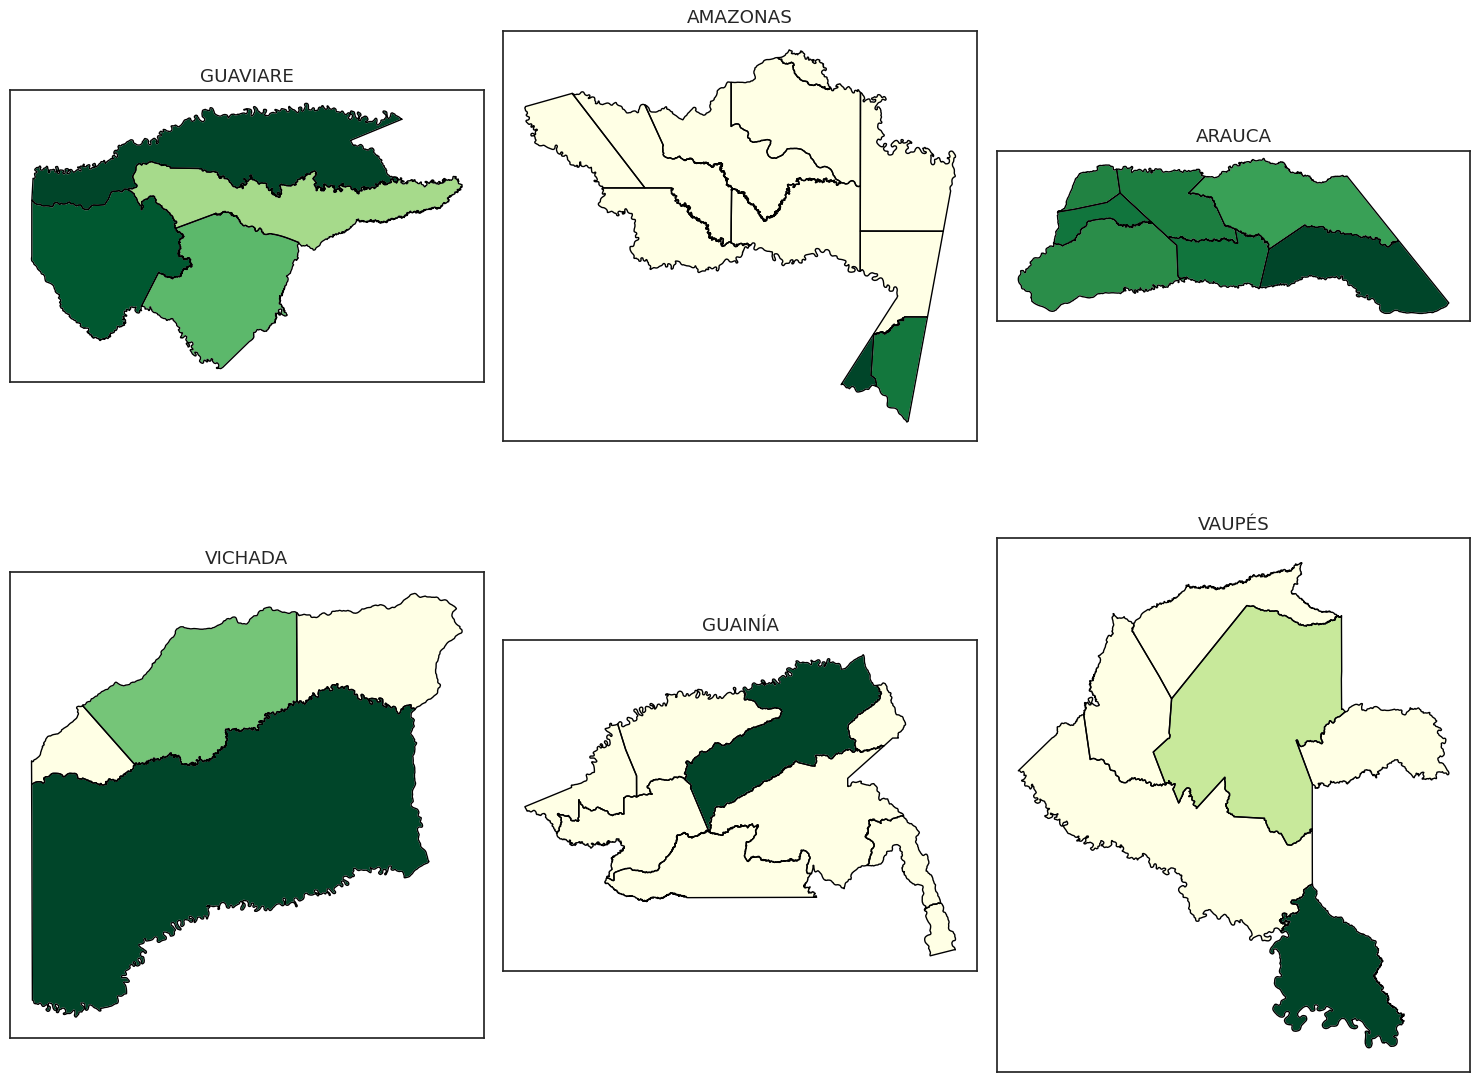

In [109]:
# Obtener la lista de meses (columnas)
departamentos_deseados = ['GUAVIARE', 'AMAZONAS', 'ARAUCA', 'VICHADA', 'GUAINÍA', 'VAUPÉS']

# Calcular el número de filas y columnas para la matriz de subplots
num_filas = 2
num_columnas = 3
num_graficos = num_filas * num_columnas

# Crear la figura y los subplots
fig, axes = plt.subplots(num_filas, num_columnas, figsize=(15, 15))

# Iterar a través de los meses y los subplots
for i, dep in enumerate(departamentos_deseados):
    fila = i // num_columnas
    columna = i % num_columnas
    ax = axes[fila, columna]
    Departamento = Mun.loc[Mun['NOM_DEPART'] == dep]

    # Configurar el estilo y plot
    with plt.style.context('seaborn-dark'):
        Departamento.plot(column='sep', cmap='YlGn', vmin=0, vmax=Departamento['sep'].max(), ax=ax)

        # Dibujar límites exteriores de los departamentos
        Departamento.boundary.plot(ax=ax, linewidth=1, color='black')

        ax.set_title(dep)

    # Quitar etiquetas de ejes
    ax.set_xticks([])
    ax.set_yticks([])

# Ajustar espaciado entre subplots
plt.tight_layout()
plt.subplots_adjust(top=0.9)

plt.show()